# Market Crash Scenario Simulator

**INTRODUCTION**

This project develops designed to stress test portfolio under adverse conditions.

The simulator generates asset returns across different crash scenarios and evaluates key risk metrics such as drawdown, recovery time, volatility, and risk-adjusted performance.

In the context of quantitative finance and risk management, scenario analysis is essential because extreme market movements (or so-called "tail events") often dominates long-term portfolio outcomes. This project applies quantitative methods to visualize and interpret portfolio resilience across regimes, demonstrating how risk managers anticipate and measure vulnerability. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from scipy import stats
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

print("Environment Setup Complete!")
print(f"NumPy version:{np.__version__}")
print(f"Pandas version:{pd.__version__}")

Environment Setup Complete!
NumPy version:1.24.2
Pandas version:2.2.3


In [2]:
ASSETS = ['Stocks', 'Bonds', 'Gold', 'Crypto']
SIMULATION_DAYS = 730
START_DATE ='2024-01-01'
TARGET_VOLATILITIES = {
    'Stocks': 0.20,
    'Bonds': 0.03,
    'Gold': 0.10,
    'Crypto': 0.80
}
TARGET_RETURNS = {
    'Stocks': 0.09,
    'Bonds': 0.04,
    'Gold': 0.07,
    'Crypto': 0.20
}

print("Project Parameters Defined:")
print(f"Assets: {ASSETS}")
print(f"Simulation Period: {SIMULATION_DAYS}")
print(f"Target Volatilities: {TARGET_VOLATILITIES}")

Project Parameters Defined:
Assets: ['Stocks', 'Bonds', 'Gold', 'Crypto']
Simulation Period: 730
Target Volatilities: {'Stocks': 0.2, 'Bonds': 0.03, 'Gold': 0.1, 'Crypto': 0.8}


Normal Market Correlations
        Stocks  Bonds  Gold  Crypto
Stocks     1.0  -0.20  0.10    0.30
Bonds     -0.2   1.00  0.05   -0.10
Gold       0.1   0.05  1.00    0.25
Crypto     0.3  -0.10  0.25    1.00

Crisis Market Correlations
        Stocks  Bonds  Gold  Crypto
Stocks     1.0   -0.1   0.3     0.7
Bonds     -0.1    1.0   0.2     0.1
Gold       0.3    0.2   1.0     0.4
Crypto     0.7    0.1   0.4     1.0


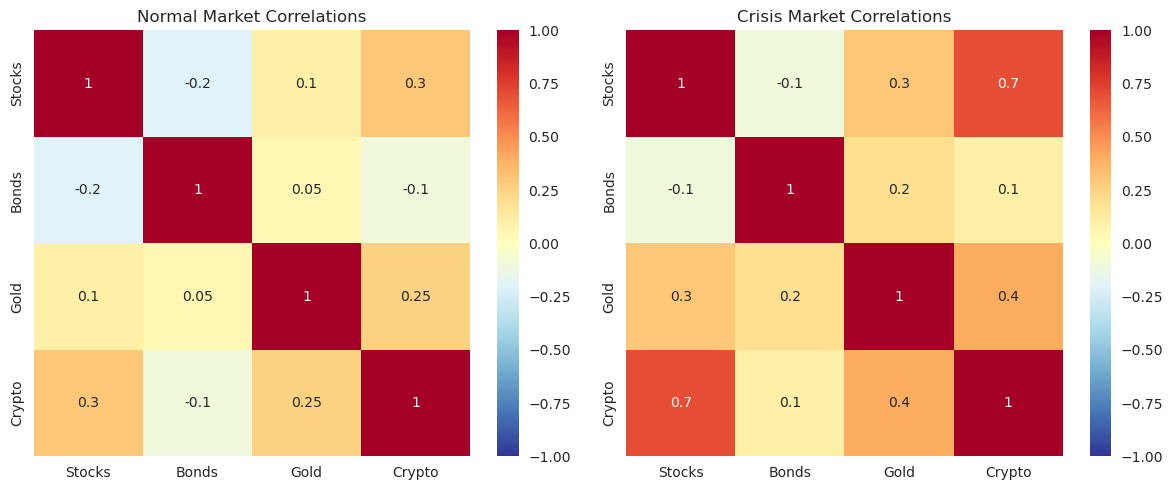

In [3]:
NORMAL_CORRELATIONS = np.array([
    [     1.00,  -0.20,   0.10,   0.30],
    [    -0.20,   1.00,   0.05,  -0.10],  
    [     0.10,   0.05,   1.00,   0.25],
    [     0.30,  -0.10,   0.25,   1.00]
])
CRISIS_CORRELATIONS = np.array([
    [     1.00,  -0.10,   0.30,   0.70],
    [    -0.10,   1.00,   0.20,   0.10],
    [     0.30,   0.20,   1.00,   0.40],
    [     0.70,   0.10,   0.40,   1.00]
])
normal_corr_df = pd.DataFrame(NORMAL_CORRELATIONS, index=ASSETS, columns=ASSETS)
crisis_corr_df = pd.DataFrame(CRISIS_CORRELATIONS, index=ASSETS, columns=ASSETS)

print("Normal Market Correlations")
print(normal_corr_df)
print("\nCrisis Market Correlations")
print(crisis_corr_df)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(normal_corr_df, annot=True, cmap='RdYlBu_r', center=0, ax=ax1, vmin=-1, vmax=1)
ax1.set_title('Normal Market Correlations')
sns.heatmap(crisis_corr_df, annot=True, cmap='RdYlBu_r', center=0, ax=ax2, vmin=-1, vmax=1)
ax2.set_title('Crisis Market Correlations')

plt.tight_layout()
plt.show()

In [42]:
def generate_synthetic_returns(n_days, target_returns, target_volatilities, correlation_matrix, assets, random_seed=42):
    """
    Generate synthetic daily returns for multiple assets
    """
    
    np.random.seed(random_seed)
    daily_returns = {}
    daily_volatilities = {}
    
    for asset in assets:
        daily_returns[asset] = target_returns[asset] / 252
        daily_volatilities[asset] = target_volatilities[asset] / np.sqrt(252)
        
    daily_means = [daily_returns[asset] for asset in assets]
    daily_stds = [daily_volatilities[asset] for asset in assets]
    
    covariance_matrix = np.zeros((len(assets), (len(assets))))
    for i in range(len(assets)):
        for j in range(len(assets)):
            covariance_matrix[i, j] = (correlation_matrix[i, j] * daily_stds[i] * daily_stds[j])

    random_returns = np.random.multivariate_normal(
        mean = daily_means,
        cov = covariance_matrix,
        size = n_days
    )
    
    start_date = pd.to_datetime(START_DATE)
    date_range = pd.date_range(start=start_date, periods=n_days, freq='D')
                                 
    returns_df = pd.DataFrame(random_returns, index=date_range, columns=assets)
    
    return returns_df

print("Generating synthetic returns for normal market conditions...")
normal_returns = generate_synthetic_returns(
    n_days = SIMULATION_DAYS,
    target_returns = TARGET_RETURNS,
    target_volatilities = TARGET_VOLATILITIES,
    correlation_matrix = NORMAL_CORRELATIONS,
    assets = ASSETS
)

print(f"Generate {len(normal_returns)} days of return data")
print(f"Data range: {normal_returns.index[0]} to {normal_returns.index[-1]}")
print("\nFirst 10 days of returns:")
print(normal_returns.head(10))

print("\nActual statistics vs targets:")
print("Annual Returns (Target vs Actual)")
for asset in ASSETS:
    target = TARGET_RETURNS[asset] * 100
    actual = normal_returns[asset].mean() * 252 * 100
    print(f"{asset:8s}: {target:5.1f}% vs {actual:5.1f}%")
    
print("\nAnnual Volatilities (Target vs Actual)")
for asset in ASSETS:
    target = TARGET_VOLATILITIES[asset] * 100
    actual = normal_returns[asset].std() * np.sqrt(252) * 100
    print(f"{asset:8s}: {target:5.1f}% vs {actual:5.1f}%")

Generating synthetic returns for normal market conditions...
Generate 730 days of return data
Data range: 2024-01-01 00:00:00 to 2025-12-30 00:00:00

First 10 days of returns:
            Stocks   Bonds    Gold  Crypto
2024-01-01 -0.0033 -0.0026 -0.0044 -0.0240
2024-01-02 -0.0014 -0.0015 -0.0090  0.0131
2024-01-03  0.0087  0.0008  0.0039  0.0238
2024-01-04 -0.0236  0.0022  0.0100 -0.0099
2024-01-05  0.0082  0.0026  0.0074  0.0514
2024-01-06 -0.0081  0.0031 -0.0026 -0.0728
2024-01-07  0.0037 -0.0005  0.0082  0.0279
2024-01-08 -0.0009 -0.0032  0.0049  0.0312
2024-01-09 -0.0121  0.0026 -0.0050  0.0026
2024-01-10 -0.0240  0.0007  0.0077 -0.0081

Actual statistics vs targets:
Annual Returns (Target vs Actual)
Stocks  :   9.0% vs  28.0%
Bonds   :   4.0% vs   2.2%
Gold    :   7.0% vs   2.9%
Crypto  :  20.0% vs   4.7%

Annual Volatilities (Target vs Actual)
Stocks  :  20.0% vs  19.7%
Bonds   :   3.0% vs   3.1%
Gold    :  10.0% vs   9.8%
Crypto  :  80.0% vs  75.5%


In [5]:
class CrashScenarios:
    def __init__(self, base_returns, correlation_matrix, daily_stds, assets):
        """
        Initialize crash scenarios with your existing data...
        """
        self.base_returns = base_returns
        self.base_correlation = correlation_matrix
        self.daily_stds = daily_stds
        self.assets = assets
        self.n_assets = len(assets)
        
    def market_crash_scenario(self, crash_start_day=100, crash_duration=30, crash_severity=0.4, recovery_duration=60):
        """
        Scenario 1: Sudden Market Crash (Like 2008 or 2020)
        -Sharp decline across all risky assets
        -Flight to quality (Bonds perform better)
        -Increase volatility during crash period
        """
        modified_returns = self.base_returns.copy()
        
        crash_end = crash_start_day + crash_duration
        recovery_end = crash_end + recovery_duration
        
        crash_multipliers = {
            'Stocks': -crash_severity,
            'Bonds': crash_severity * 0.3,
            'Gold': crash_severity * 0.2,
            'Crypto': -crash_severity * 1.2
        }
        
        for i, asset in enumerate(self.assets):
            crash_shock = np.random.normal(crash_multipliers[asset], self.daily_stds[i] * 2, crash_duration)
            modified_returns.iloc[crash_start_day:crash_end, i] += crash_shock
            
            recovery_multiplier = -crash_multipliers[asset] * 6
            recovery_shock = np.random.normal(recovery_multiplier/recovery_duration, self.daily_stds[i] * 1.5, recovery_duration)
            modified_returns.iloc[crash_end:recovery_end, i] += recovery_shock
            
        return modified_returns
    
    def recession_scenario(self, recession_start=50, recession_duration=180):
        """
        Scenario 2: Prolonged Recession
        -Gradual decline over extended period
        -Different assets affected at different times
        -Lower growth expectations
        """
        modified_returns = self.base_returns.copy()
        recession_end = recession_start + recession_duration
        recession_impacts = {
            'Stocks': -0.15,
            'Bonds': 0.05,
            'Gold': 0.08,
            'Crypto': -0.20
        }
        
        for i, asset in enumerate(self.assets):
            daily_impact = recession_impacts[asset] / recession_duration
            recession_drift = np.random.normal(daily_impact, self.daily_stds[i] * 0.5, recession_duration)
            modified_returns.iloc[recession_start:recession_end, i] += recession_drift
            
        return modified_returns
    
    def correlation_breakdown_scenario(self, breakdown_start=200, breakdown_duration=90):
        """
        Scenario 3: Correlation Breakdown (Contagion/Liquidity Crisis)
        -Traditional diversification fails
        -All correlations move towards 1 (everything falls together)
        -Extreme tail events
        """
        modified_returns = self.base_returns.copy()
        breakdown_end = breakdown_start + breakdown_duration
        
        crisis_correlation = np.full((self.n_assets, self.n_assets), 0.8)
        np.fill_diagonal(crisis_correlation, 1.0)
        
        crisis_correlation[0, 3] = 0.9
        crisis_correlation[3, 0] = 0.9
        
        crisis_cov = np.zeros((self.n_assets, self.n_assets))
        for i in range(self.n_assets):
            for j in range(self.n_assets):
                crisis_std_i = self.daily_stds[i] * 2.5
                crisis_std_j = self.daily_stds[j] * 2.5
                crisis_cov[i, j] = crisis_correlation[i, j] * crisis_std_i * crisis_std_j
        
        crisis_returns = np.random.multivariate_normal(
            mean = [-0.02, 0.001, 0.001, -0.03],
            cov = crisis_cov,
            size = breakdown_duration
        )
        
        modified_returns.iloc[breakdown_start:breakdown_end, :] = crisis_returns
        
        return modified_returns
    
    def generate_all_scenarios(self):
        """
        Generate all three scenarios
        Returns dictionary with scenario names and modified return data
        """
        scenarios = {
            'baseline': self.base_returns,
            'market_crash': self.market_crash_scenario(),
            'recession': self.recession_scenario(),
            'correlation_breakdown': self.correlation_breakdown_scenario()
        }
        
        return scenarios
    
    def scenario_summary(self, scenarios):
        """
        Create summary statistics for each scenario
        """
        summary = pd.DataFrame()
        
        for scenario_name, returns in scenarios.items():
            annual_returns = returns.mean() * 252
            annual_volatility = returns.std() * np.sqrt(252)
            sharpe_ratio = annual_returns / annual_volatility
            
            cumulative_returns = (1 + returns).cumprod()
            rolling_max = cumulative_returns.expanding().max()
            drawdown = (cumulative_returns - rolling_max) / rolling_max
            max_drawdown = drawdown.min()
            
            scenario_stats = pd.DataFrame({
                'Annual_Return': annual_returns,
                'Annual_Volatility': annual_volatility,
                'Sharpe_Ratio': sharpe_ratio,
                'Max_Drawdown': max_drawdown
            })
            scenario_stats['Scenario'] = scenario_name
            summary = pd.concat([summary, scenario_stats])
            
        return summary.reset_index()
    
print("Creating crash scenarios...")

daily_stds = []
for asset in ASSETS:
    daily_stds.append(TARGET_VOLATILITIES[asset] / np.sqrt(252))
    
print(f"Daily standard deviations: {[f'{std:.4f}' for std in daily_stds]}")

crash_generator = CrashScenarios(
    base_returns = normal_returns,
    correlation_matrix = NORMAL_CORRELATIONS,
    daily_stds = daily_stds,
    assets= ASSETS
)

scenarios = crash_generator.generate_all_scenarios()
scenario_summary = crash_generator.scenario_summary(scenarios)

print("Scenario Summary:")
print(scenario_summary.round(4))

print("\nFirst 10 days of each scenario:")
for name, data in scenarios.items():
    print(f"\n{name.upper}:")
    print(data.head(10).round(4))

Creating crash scenarios...
Daily standard deviations: ['0.0126', '0.0019', '0.0063', '0.0504']
Scenario Summary:
     index  Annual_Return  Annual_Volatility  Sharpe_Ratio  Max_Drawdown  \
0   Stocks         0.2795             0.1973        1.4167       -0.2211   
1    Bonds         0.0221             0.0307        0.7191       -0.0287   
2     Gold         0.0288             0.0978        0.2947       -0.1464   
3   Crypto         0.0472             0.7548        0.0626       -0.8729   
4   Stocks        -3.0409             1.3139       -2.3143       -1.0000   
5    Bonds         1.0050             0.3838        2.6183       -0.5206   
6     Gold         0.6419             0.2820        2.2766       -0.5165   
7   Crypto        -3.5514             1.7862       -1.9883       -1.0000   
8   Stocks         0.2380             0.2028        1.1733       -0.2342   
9    Bonds         0.0412             0.0320        1.2884       -0.0226   
10    Gold         0.0385             0.1008      

In [39]:
class PortfolioSimulator:
    def __init__(self, scenarios, assets):
        """
        Initialize portfolio simulator with crash scenarios
        """
        self.scenarios = scenarios
        self.assets = assets
        self.n_assets = len(assets)
        
    def create_portfolio_strategies(self):
        """
        Define different portfolio allocation strategies
        """
        strategies = {
            'equal_weight': np.array([0.25, 0.25, 0.25, 0.25]),
            'conservative': np.array([0.20, 0.50, 0.20, 0.10]),
            'aggresive': np.array([0.50, 0.10, 0.10, 0.30]),
            'balanced': np.array([0.40, 0.30, 0.15, 0.15]),
            'safe_haven': np.array([0.10, 0.60, 0.30, 0.00]),
            'crypto_focused': np.array([0.30, 0.20, 0.10, 0.40])
        }
        return strategies
    
    def calculate_portfolio_returns(self, returns_data, weights):
        """
        Calculate portfolio returns given assets returns and weights
        
        Args:
            returns_data: DataFrame of asset returns
            weights: numpy array of portfolio weights
            
        Returns:
            Series of portfolio returns
        """
        portfolio_returns = returns_data.values @ weights
        return pd.Series(portfolio_returns, index=returns_data.index)
    
    def calculate_portfolio_metrics(self, portfolio_returns):
        """
        Calculate comprehensive portfolio performance metrics
        """
        total_return = (1 + portfolio_returns).prod() - 1
        annual_return = portfolio_returns.mean() * 252
        annual_volatility = portfolio_returns.std() * np.sqrt(252)
        
        sharpe_ratio = annual_return / annual_volatility if annual_volatility > 0 else 0
        
        downside_returns = portfolio_returns[portfolio_returns < 0]
        downside_volatility = downside_returns.std() * np.sqrt(252) if len(downside_returns) > 0 else 0
        sortino_ratio = annual_return / downside_volatility if downside_volatility > 0 else 0
        
        cumulative_returns = (1 + portfolio_returns).cumprod()
        rolling_max = cumulative_returns.expanding().max()
        drawdown = (cumulative_returns - rolling_max) / rolling_max
        max_drawdown = drawdown.min()
        
        max_dd_date = drawdown.idxmin()
        recovery_data = cumulative_returns[max_dd_date :]
        recovery_threshold = rolling_max.loc[max_dd_date]
        recovery_achieved = recovery_data >= recovery_threshold
        
        if recovery_achieved.any():
            recovery_time = (recovery_achieved.idxmax() - max_dd_date).days
        else:
            recovery_time = np.nan
            
        var_95 = portfolio_returns.quantile(0.05)
        expected_shortfall = portfolio_returns[portfolio_returns <= var_95].mean()
        
        return {
            'Total_Return': total_return,
            'Annual_Return': annual_return,
            'Annual_Volatility': annual_volatility,
            'Sharpe_Ratio': sharpe_ratio,
            'Sortino_Ratio': sortino_ratio,
            'Max_Drawdown': max_drawdown,
            'Recovery_Days': recovery_time,
            'VaR_95': var_95,
            'Expected_Shortfall': expected_shortfall,
            'Win_Rate': (portfolio_returns > 0).mean(),
            'Best_Day': portfolio_returns.max(),
            'Worst_Day': portfolio_returns.min()
        }
        
    def simulate_all_strategies(self):
        """
        Run all portfolio strategies across all scenarios
        """
        strategies = self.create_portfolio_strategies()
        results = {}
        
        for scenario_name, returns_data in self.scenarios.items():
            scenario_results = {}
            
            for strategy_name, weights in strategies.items():
                portfolio_returns = self.calculate_portfolio_returns(returns_data, weights)
                metrics = self.calculate_portfolio_metrics(portfolio_returns)
                
                scenario_results[strategy_name] = {
                    'weights': weights,
                    'returns': portfolio_returns,
                    'metrics': metrics
                }
                
            results[scenario_name] = scenario_results
            
        return results
    def create_performance_summary(self, results):
        """
        Create summary table of all strategy performances across scenarios
        """
        summary_data = []
        
        for scenario_name, scenario_results in results.items():
            for strategy_name, strategy_data in scenario_results.items():
                metrics = strategy_data['metrics']
                
                row = {
                    'Scenario': scenario_name,
                    'Strategy': strategy_name,
                    **metrics
                }
                summary_data.append(row)
                
        return pd.DataFrame(summary_data)
    
    def calculate_efficient_frontier(self, returns_data, n_portfolios=100):
        """
        Calculate efficient frontier using mean-variance optimization
        """
        expected_returns = returns_data.mean() * 252
        cov_matrix = returns_data.cov() * 252
        
        def portfolio_variance(weights, cov_matrix):
            return weights.T @ cov_matrix @ weights
        
        def portfolio_return(weights, expected_returns):
            return weights @ expected_returns
        
        constraints = [
            {'type': 'eq', 'fun':lambda x: np.sum(x)-1}
        ]
        bounds = [(0, 1) for _ in range(self.n_assets)]
        
        min_ret = expected_returns.min()
        max_ret = expected_returns.max()
        target_returns = np.linspace(min_ret, max_ret, n_portfolios)
        efficient_portfolios = []
        
        for target_ret in target_returns:
            ret_constraint = {
                'type': 'eq',
                'fun': lambda x, target=target_ret: portfolio_return(x, expected_returns) - target
            }
            
            result = minimize(
                portfolio_variance,
                x0=np.array([1/self.n_assets] * self.n_assets),
                args=(cov_matrix,),
                method='SLSQP',
                bounds=bounds,
                constraints=[constraints[0], ret_constraint]
            )
            
            if result.success:
                efficient_portfolios.append({
                    'return': target_ret,
                    'volatility': np.sqrt(result.fun),
                    'weights': result.x
                })
                
        return pd.DataFrame(efficient_portfolios)
    
print("Setting up portfolio simulatios...")

portfolio_sim = PortfolioSimulator(scenarios, ASSETS)

print("Portfolio strategies defined:")
strategies = portfolio_sim.create_portfolio_strategies()
for name, weights in strategies.items():
    weight_str = "|".join([f"-{asset}: {w:.1%}" for asset, w in zip(ASSETS, weights)])
    print(f"{name:15s}: {weight_str}")
    
print("\nRunning simulations across all scenarios...")
simulation_results = portfolio_sim.simulate_all_strategies()

print("Creating performance summary...")
performance_summary = portfolio_sim.create_performance_summary(simulation_results)

print("\nTop performance strategies by Sharpe Ratio in each scenario:")
for scenario in ['baseline', 'market_crash', 'recession', 'correlation_breakdown']:
    scenario_data = performance_summary[performance_summary['Scenario'] == scenario]
    best_strategy = scenario_data.loc[scenario_data['Sharpe_Ratio'].idxmax()]
    print(f"{scenario:20s}: {best_strategy['Strategy']:15s} (Sharpe: {best_strategy['Sharpe_Ratio']:.3f})")

print(f"\nFull performance summary shape: {performance_summary.shape}")
print("First view rows")
print(performance_summary[['Scenario', 'Strategy', 'Annual_Return', 'Annual_Volatility', 'Sharpe_Ratio', 'Max_Drawdown']].head(10))

Setting up portfolio simulatios...
Portfolio strategies defined:
equal_weight   : -Stocks: 25.0%|-Bonds: 25.0%|-Gold: 25.0%|-Crypto: 25.0%
conservative   : -Stocks: 20.0%|-Bonds: 50.0%|-Gold: 20.0%|-Crypto: 10.0%
aggresive      : -Stocks: 50.0%|-Bonds: 10.0%|-Gold: 10.0%|-Crypto: 30.0%
balanced       : -Stocks: 40.0%|-Bonds: 30.0%|-Gold: 15.0%|-Crypto: 15.0%
safe_haven     : -Stocks: 10.0%|-Bonds: 60.0%|-Gold: 30.0%|-Crypto: 0.0%
crypto_focused : -Stocks: 30.0%|-Bonds: 20.0%|-Gold: 10.0%|-Crypto: 40.0%

Running simulations across all scenarios...
Creating performance summary...

Top performance strategies by Sharpe Ratio in each scenario:
baseline            : safe_haven      (Sharpe: 1.222)
market_crash        : safe_haven      (Sharpe: 2.677)
recession           : safe_haven      (Sharpe: 1.422)
correlation_breakdown: safe_haven      (Sharpe: 1.083)

Full performance summary shape: (24, 14)
First view rows
       Scenario        Strategy  Annual_Return  Annual_Volatility  \
0      ba

Running comprehensive Market Crash Simulator analysis...
Generating visualizations...



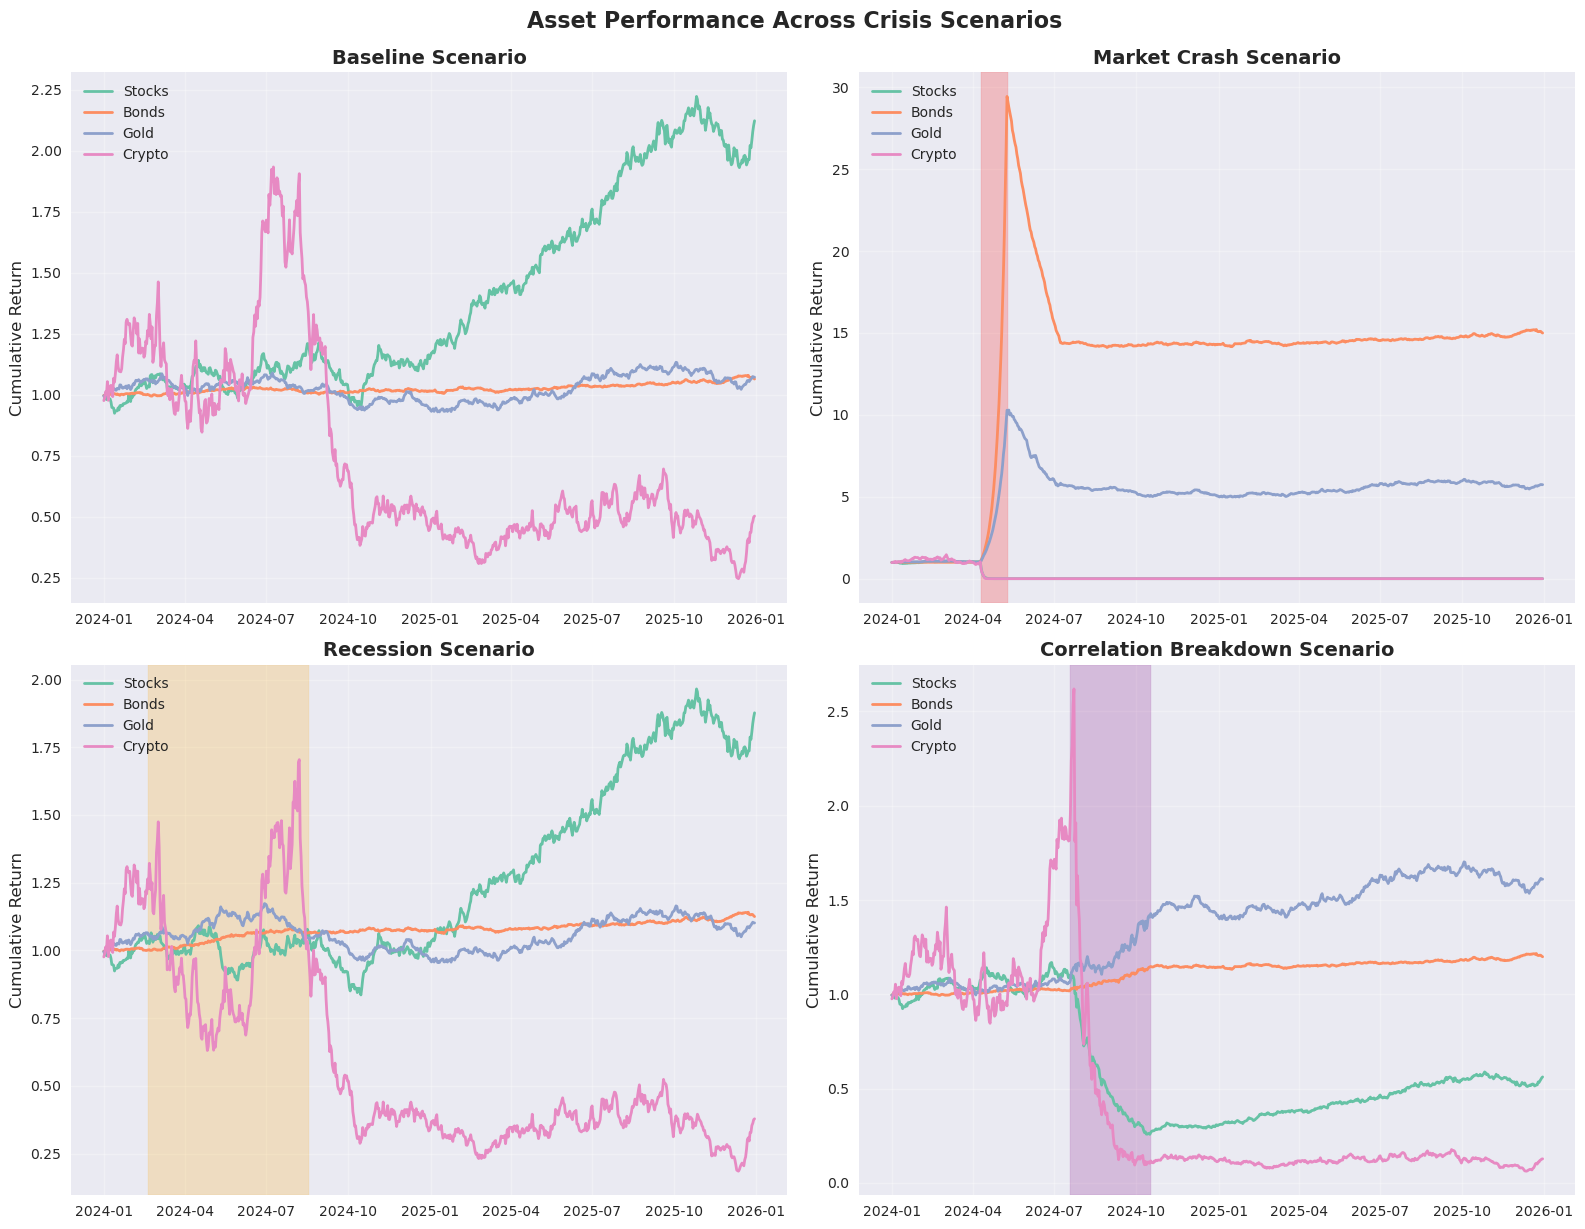

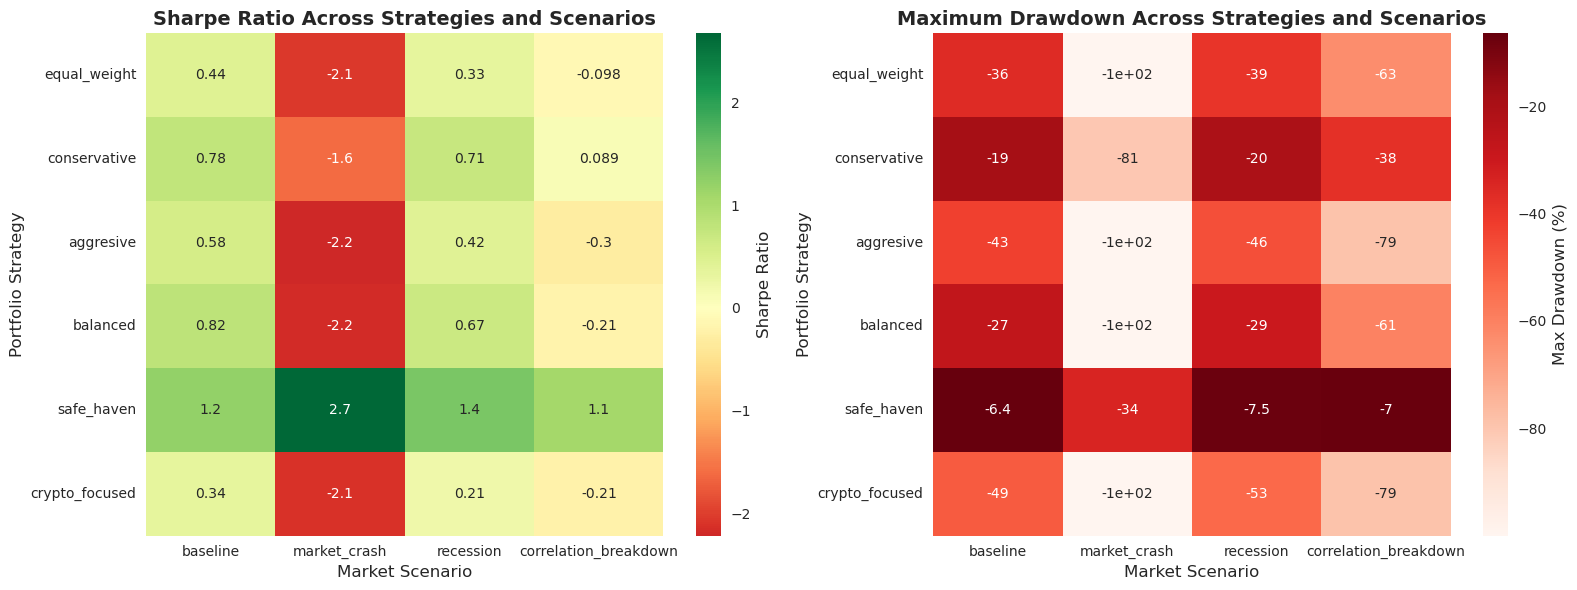

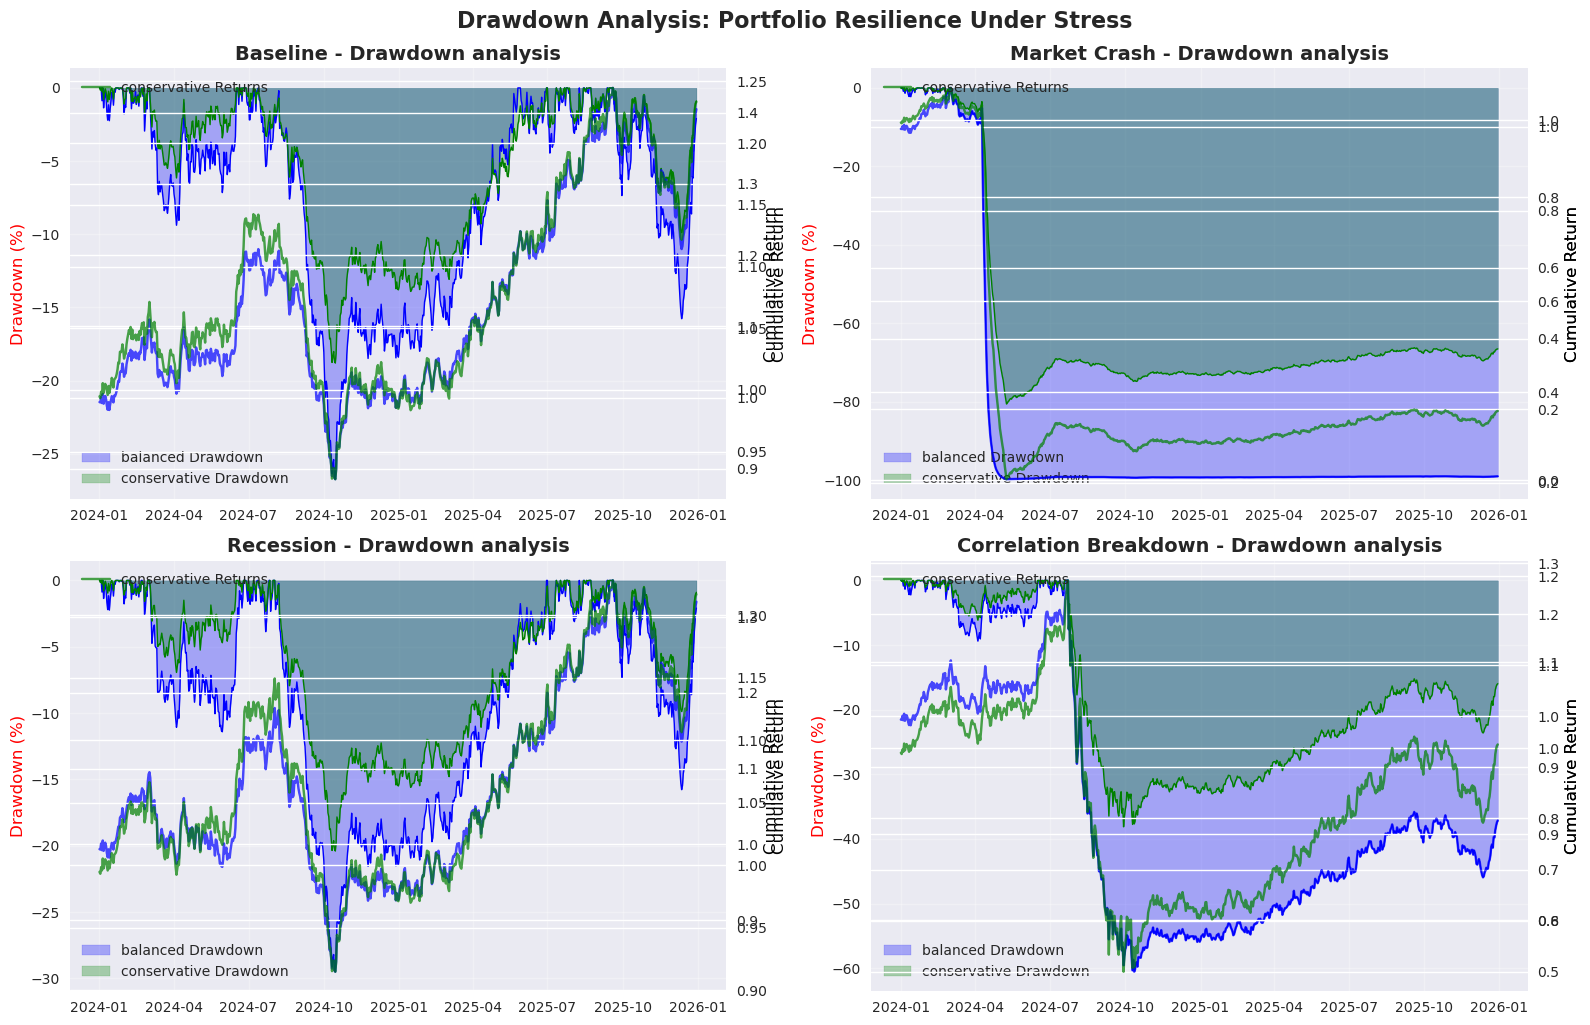


Processing baseline scenario...
 equal_weight: Return=9.44%, Vol=21.36%
 conservative: Return=7.74%, Vol=9.95%
 aggresive: Return=15.90%, Vol=27.35%
 balanced: Return=12.98%, Vol=15.78%
 safe_haven: Return=4.98%, Vol=4.08%
 crypto_focused: Return=11.00%, Vol=32.54%

Processing market_crash scenario...
 equal_weight: Return=-123.63%, Vol=60.21%
 conservative: Return=-33.24%, Vol=20.51%
 aggresive: Return=-242.12%, Vol=109.12%
 balanced: Return=-135.13%, Vol=62.16%
 safe_haven: Return=49.15%, Vol=18.36%
 crypto_focused: Return=-206.76%, Vol=97.95%

Processing recession scenario...
 equal_weight: Return=7.21%, Vol=22.03%
 conservative: Return=7.30%, Vol=10.24%
 aggresive: Return=11.82%, Vol=28.06%
 balanced: Return=10.90%, Vol=16.16%
 safe_haven: Return=6.00%, Vol=4.22%
 crypto_focused: Return=7.18%, Vol=33.56%

Processing correlation_breakdown scenario...
 equal_weight: Return=-3.04%, Vol=31.09%
 conservative: Return=1.40%, Vol=15.78%
 aggresive: Return=-11.70%, Vol=39.47%
 balanced: Re

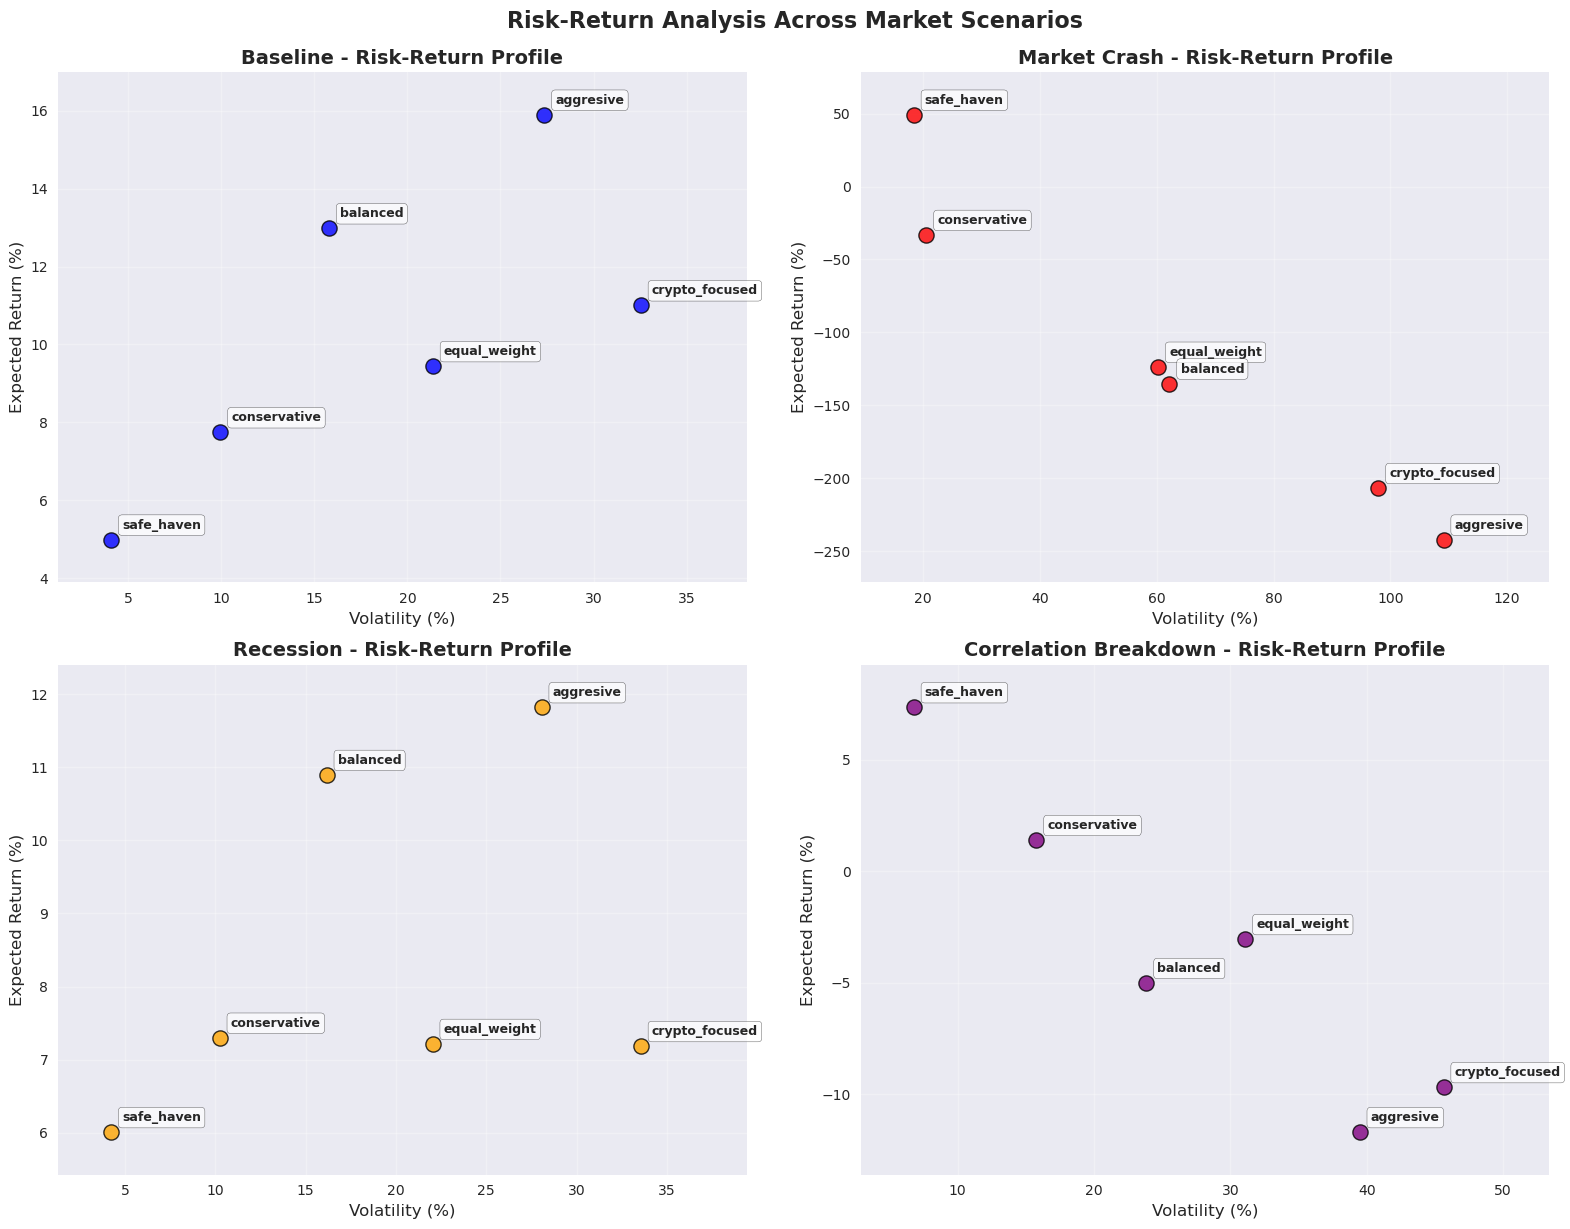

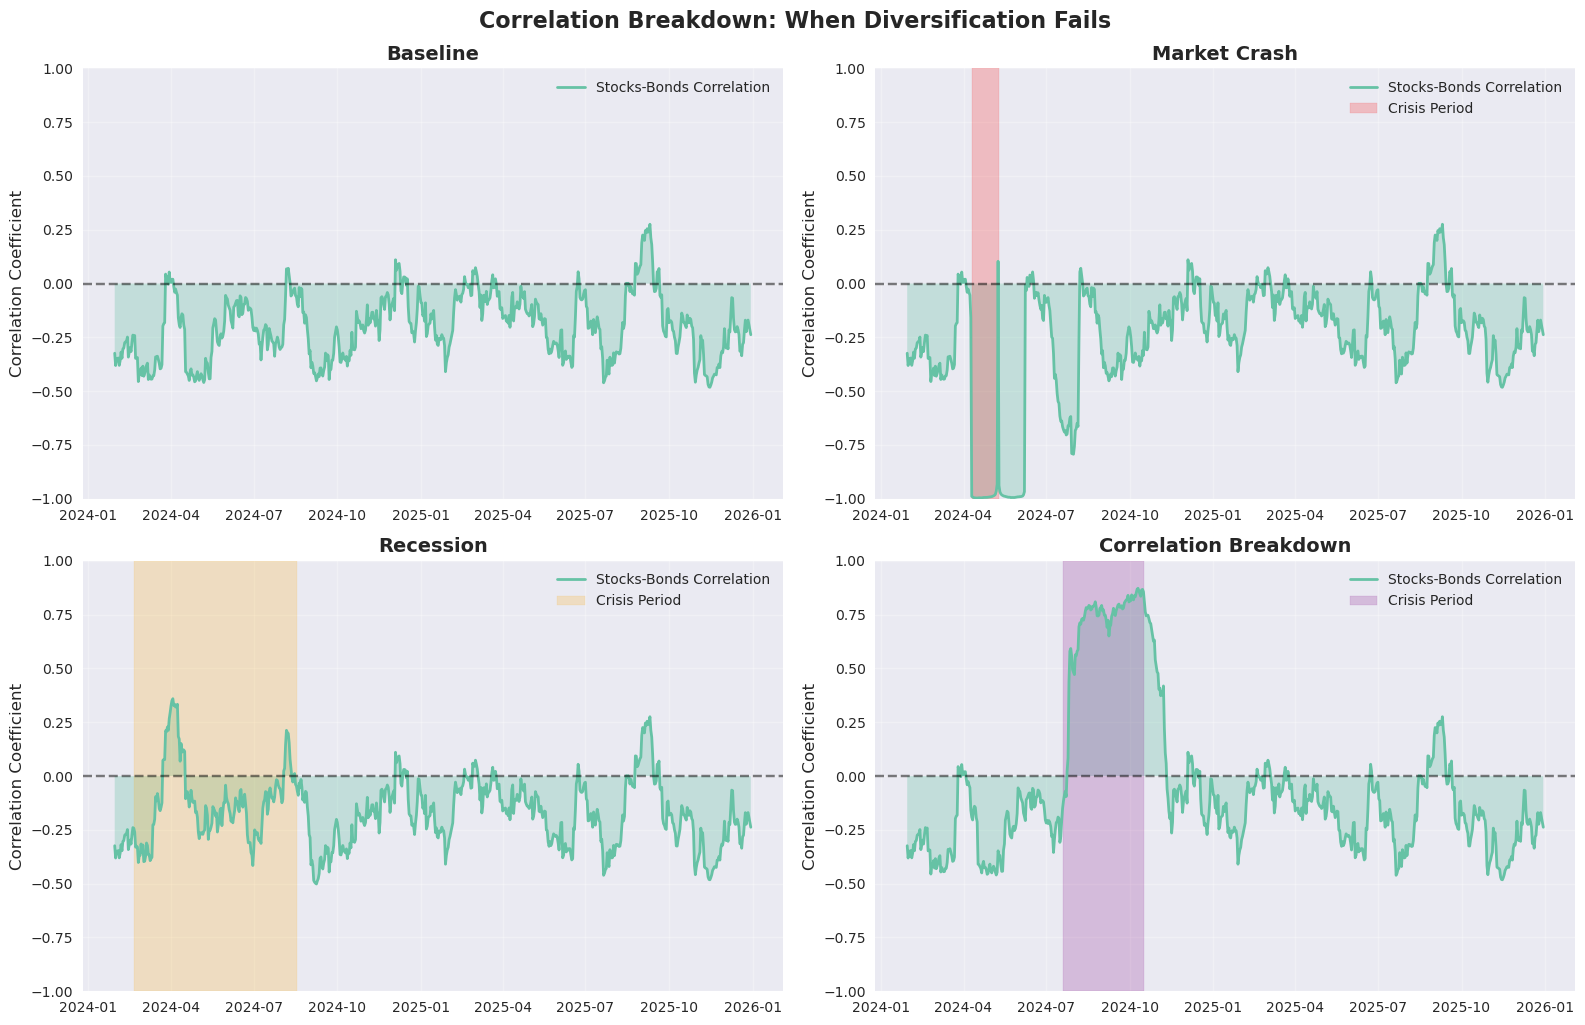

MARKET CRASH SIMULATOR - COMPREHENSIVE ANALYSIS REPORT

1.STRATEGY PERFORMANCE RANKINGS
--------------------------------------------------

BASELINE SCENARIO:
 safe_haven     : Sharpe= 1.222, Return=  5.0%, DD= -6.4%
 balanced       : Sharpe= 0.823, Return= 13.0%, DD=-26.7%
 conservative   : Sharpe= 0.778, Return=  7.7%, DD=-18.8%
 aggresive      : Sharpe= 0.581, Return= 15.9%, DD=-42.6%
 equal_weight   : Sharpe= 0.442, Return=  9.4%, DD=-36.3%
 crypto_focused : Sharpe= 0.338, Return= 11.0%, DD=-49.3%

MARKET CRASH SCENARIO:
 safe_haven     : Sharpe= 2.677, Return= 49.1%, DD=-33.9%
 conservative   : Sharpe=-1.621, Return=-33.2%, DD=-80.6%
 equal_weight   : Sharpe=-2.054, Return=-123.6%, DD=-99.6%
 crypto_focused : Sharpe=-2.111, Return=-206.8%, DD=-100.0%
 balanced       : Sharpe=-2.174, Return=-135.1%, DD=-99.8%
 aggresive      : Sharpe=-2.219, Return=-242.1%, DD=-100.0%

RECESSION SCENARIO:
 safe_haven     : Sharpe= 1.422, Return=  6.0%, DD= -7.5%
 conservative   : Sharpe= 0.713, Ret

In [40]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

class CrashAnalyzer:
    """
    Advanced analysis class for Market Crash Simulator
    Creates publication-quality visualizations and comprehensive risk analysis
    """
    
    def __init__(self, simulation_results, scenarios, assets):
        self.results = simulation_results
        self.scenarios = scenarios
        self.assets = assets
        
    def plot_scenario_comparison(self):
        """
        Plot 1: Comprehensive scenario comparison showing cumulative returns
        """
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        scenarios_to_plot = ['baseline', 'market_crash', 'recession', 'correlation_breakdown']
        colors = ['green', 'red', 'orange', 'purple']

        for i, (scenario, color) in enumerate(zip(scenarios_to_plot, colors)):
            ax = [ax1, ax2, ax3, ax4][i]
            returns_data = self.scenarios[scenario]
            
            cumulative_returns = (1 + returns_data).cumprod()
            
            for asset in self.assets:
                ax.plot(cumulative_returns.index, cumulative_returns[asset], label=asset, linewidth=2)
              
            ax.set_title(f'{scenario.replace("_", " ").title()} Scenario', fontsize=14, fontweight='bold')
            ax.legend(loc='upper left')
            ax.grid(True, alpha=0.3)
            ax.set_ylabel('Cumulative Return')
              
            if scenario == 'market_crash':
                ax.axvspan(cumulative_returns.index[100], cumulative_returns.index[130], alpha=0.2, color='red', label='Crash Period')
            elif scenario == 'recession':
                ax.axvspan(cumulative_returns.index[50], cumulative_returns.index[230], alpha=0.2, color='orange', label='Recession Period')
            elif scenario == 'correlation_breakdown':
                ax.axvspan(cumulative_returns.index[200], cumulative_returns.index[290], alpha=0.2, color='purple', label='Crisis Period')
        
        plt.tight_layout()
        plt.suptitle('Asset Performance Across Crisis Scenarios', fontsize=16, fontweight='bold', y=1.02)
        plt.show()
        
    def plot_portfolio_performance_heat(self):
        """
        Plot 2: Performance heatmap showing strategy effectiveness across scenarios
        """
        sharpe_matrix = []
        strategies = list(self.results['baseline'].keys())
        scenarios = list(self.results.keys())
        
        for strategy in strategies:
            strategy_row = []
            for scenario in scenarios:
                sharpe = self.results[scenario][strategy]['metrics']['Sharpe_Ratio']
                strategy_row.append(sharpe)
            sharpe_matrix.append(strategy_row)
            
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        sharpe_df = pd.DataFrame(sharpe_matrix, index=strategies, columns=scenarios)
        sns.heatmap(sharpe_df, annot=True, cmap='RdYlGn', center=0, ax=ax1, cbar_kws={'label': 'Sharpe Ratio'})
        ax1.set_title('Sharpe Ratio Across Strategies and Scenarios', fontweight='bold')
        ax1.set_ylabel('Portfolio Strategy')
        ax1.set_xlabel('Market Scenario')
        
        dd_matrix = []
        for strategy in strategies:
            strategy_row = []
            for scenario in scenarios:
                dd = self.results[scenario][strategy]['metrics']['Max_Drawdown']
                strategy_row.append(dd * 100)
            dd_matrix.append(strategy_row)
            
        dd_df = pd.DataFrame(dd_matrix, index=strategies, columns=scenarios)
        sns.heatmap(dd_df, annot=True, cmap='Reds', ax=ax2, cbar_kws={'label': 'Max Drawdown (%)'})
        ax2.set_title('Maximum Drawdown Across Strategies and Scenarios', fontweight='bold')
        ax2.set_ylabel('Portfolio Strategy')
        ax2.set_xlabel('Market Scenario')
        
        plt.tight_layout()
        plt.show()
        
    def plot_drawdown_analysis(self):
        """
        Plot 3: Detailed drawdown analysis for key strategies
        """
        fig, axes = plt.subplots(2, 2, figsize=(16, 10)) 
        axes = axes.flatten()
        
        scenarios = ['baseline', 'market_crash', 'recession', 'correlation_breakdown']
        key_strategies = ['balanced', 'conservative']
        colors = ['blue', 'green']
        
        for i, scenario in enumerate(scenarios):
            ax=axes[i]
            
            for j, strategy in enumerate(key_strategies):
                portfolio_returns = self.results[scenario][strategy]['returns']
                cumulative_returns = (1 + portfolio_returns).cumprod()
                
                rolling_max = cumulative_returns.expanding().max()
                drawdown = (cumulative_returns - rolling_max) / rolling_max * 100
                
                ax2 = ax.twinx()
                ax2.plot(cumulative_returns.index, cumulative_returns, color=colors[j], alpha=0.7, label=f'{strategy} Returns')
                ax2.set_ylabel('Cumulative Return', color='black')
                
                ax.fill_between(drawdown.index, drawdown, 0, alpha=0.3, color=colors[j], label=f'{strategy} Drawdown')
                ax.plot(drawdown.index, drawdown, color=colors[j], linewidth=1)
                
            ax.set_title(f'{scenario.replace("_", " ").title()} - Drawdown analysis', fontweight='bold')
            ax.set_ylabel('Drawdown (%)', color='red')
            ax.legend(loc='lower left')
            ax2.legend(loc='upper left')
            ax.grid(True, alpha=0.3)
            
        plt.tight_layout()
        plt.suptitle('Drawdown Analysis: Portfolio Resilience Under Stress', fontsize=16, fontweight='bold', y=1.02)
        plt.show()
        
    def plot_risk_return_scatter(self):
        """
        Plot 4: Risk-Return scatter plot with efficient frontier
        """
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        scenarios = ['baseline', 'market_crash', 'recession', 'correlation_breakdown']
        colors = ['blue', 'red','orange','purple']
        
        for i, scenario in enumerate(scenarios):
            ax = [ax1, ax2, ax3, ax4][i]
            
            print(f"\nProcessing {scenario} scenario...")
            
            strategies = list(self.results[scenario].keys())
            returns = []
            volatilities = []
            strategy_names = []
            
            for strategy in strategies:
                try:
                    metrics = self.results[scenario][strategy]['metrics']
                    ret = metrics['Annual_Return'] * 100
                    vol = metrics['Annual_Volatility'] * 100
                    
                    if not(np.isnan(ret) or np.isnan(vol) or np.isinf(ret) or np.isinf(vol)):
                        returns.append(ret)
                        volatilities.append(vol)
                        strategy_names.append(strategy)
                        print(f" {strategy}: Return={ret:.2f}%, Vol={vol:.2f}%")
                    else:
                        print(f" {strategy}: Invalid values - Return={ret}, Vol={vol}")
                        
                except Exception as e:
                    print(f" Error processing {strategy}: {e}")
                        
                
            if len(returns) > 0 and len(volatilities) > 0:
                scatter = ax.scatter(volatilities, returns, s=120, alpha=0.8, c=colors[i], edgecolors='black', linewidth=1)
                
                
                for j, strategy in enumerate(strategy_names):
                    ax.annotate(strategy, (volatilities[j], returns[j]), xytext=(8, 8), textcoords='offset points', fontsize=9, fontweight='bold',bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
                
                vol_range = max(volatilities) - min(volatilities)
                ret_range = max(returns) - min(returns)
                
                ax.set_xlim(min(volatilities) - vol_range*0.1, max(volatilities) + vol_range*0.2)
                ax.set_ylim(min(returns) - ret_range*0.1, max(returns) + ret_range*0.1)
                
            else:
                ax.text(0.5, 0.5, f'No valid data for {scenario}', 
                       transform=ax.transAxes, ha='center', va='center', fontsize=12)
            
            ax.set_xlabel('Volatility (%)', fontsize=12)
            ax.set_ylabel('Expected Return (%)', fontsize=12)
            ax.set_title(f'{scenario.replace("_", " ").title()} - Risk-Return Profile', 
                        fontsize=14, fontweight='bold')
            ax.grid(True, alpha=0.3)
            
        plt.tight_layout()
        plt.suptitle('Risk-Return Analysis Across Market Scenarios', 
                    fontsize=16, fontweight='bold', y=1.02)
        plt.show()
            
    def plot_correlation_evolution(self):
        """
        Plot 5: Correlation evolution during crisis periods
        """
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
            
        window = 30
            
        scenarios = ['baseline', 'market_crash', 'recession', 'correlation_breakdown']
            
        for i, scenario in enumerate(scenarios):
            ax = axes[i//2, i%2]
            returns_data = self.scenarios[scenario]
            rolling_corr = returns_data['Stocks'].rolling(window).corr(returns_data['Bonds'])
                
            ax.plot(rolling_corr.index, rolling_corr, linewidth=2, label='Stocks-Bonds Correlation')
            ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
            ax.fill_between(rolling_corr.index, rolling_corr, 0, alpha=0.3)
                
            if scenario == 'market_crash':
                    ax.axvspan(rolling_corr.index[100], rolling_corr.index[130], alpha=0.2, color='red', label='Crisis Period')
            elif scenario == 'recession':
                    ax.axvspan(rolling_corr.index[50], rolling_corr.index[230], alpha=0.2, color='orange', label='Crisis Period')
            elif scenario == 'correlation_breakdown':
                    ax.axvspan(rolling_corr.index[200], rolling_corr.index[290], alpha=0.2, color='purple', label='Crisis Period')
                
            ax.set_title(f'{scenario.replace("_", " ").title()}', fontweight='bold')
            ax.set_ylabel('Correlation Coefficient')
            ax.legend()
            ax.grid(True, alpha=0.3)
            ax.set_ylim(-1, 1)
                
        plt.tight_layout()
        plt.suptitle('Correlation Breakdown: When Diversification Fails', fontsize=16, fontweight='bold', y=1.02)
        plt.show()
            
    def generate_comprehensive_report(self):
        """
        Generate a comprehensive performance report
        """
        print("=" * 80)
        print("MARKET CRASH SIMULATOR - COMPREHENSIVE ANALYSIS REPORT")
        print("=" * 80)
            
        print("\n1.STRATEGY PERFORMANCE RANKINGS")
        print("-" * 50)
            
        for scenario in self.results.keys():
            print(f"\n{scenario.upper().replace('_', ' ')} SCENARIO:")
                
            scenario_data = []
            for strategy, data in self.results[scenario].items():
                metrics = data['metrics']
                scenario_data.append({
                    'Strategy': strategy,
                    'Sharpe_Ratio': metrics['Sharpe_Ratio'],
                    'Annual_Return': metrics['Annual_Return'],
                    'Max_Drawdown': metrics['Max_Drawdown'],
                    'Recovery_Days': metrics['Recovery_Days']
                })
                    
            scenario_df = pd.DataFrame(scenario_data).sort_values('Sharpe_Ratio', ascending=False)
                
            for i, row in scenario_df.iterrows():
                print(f" {row['Strategy']:15s}: Sharpe={row['Sharpe_Ratio']:6.3f}, "
                      f"Return={row['Annual_Return']:6.1%}, DD={row['Max_Drawdown']:6.1%}")
                    
        print(f"\n2. CRISIS IMPACT ANALYSIS")
        print("-" * 50)
            
        baseline_metrics = {}
        for strategy in self.results['baseline'].keys():
            baseline_metrics[strategy] = self.results['baseline'][strategy]['metrics']['Annual_Return']
                
        for scenario in ['market_crash', 'recession', 'correlation_breakdown']:
            print(f"\n{scenario.upper().replace('_', ' ')} vs BASELINE:")
                
            for strategy in self.results[scenario].keys():
                baseline_ret = baseline_metrics[strategy]
                crisis_ret = self.results[scenario][strategy]['metrics']['Annual_Return']
                impact = (crisis_ret - baseline_ret) / baseline_ret * 100
                    
                print(f" {strategy:15s}: {impact:+6.1f}% impact on returns")
                    
        print(f"\n3. RISK METRICS SUMMARY")
        print("-" * 50)
                  
        print("MAXIMUM DRAWDOWN BY SCENARIO:")
        for scenario in self.results.keys():
            print(f"\n{scenario.upper().replace('_', ' ')}:")
            dd_data = []
            for strategy in self.results[scenario].keys():
                dd = self.results[scenario][strategy]['metrics']['Max_Drawdown']
                dd_data.append((strategy, dd))
                  
            dd_data.sort(key=lambda x: x[1])
            for strategy, dd in dd_data:
                print(f" {strategy:15s}: {dd:6.1%}")
                  
        print("\n" + "=" * 80)
            
    def run_complete_analysis(self):
        """
        Run all visualizations and analysis
        """
        print("Running comprehensive Market Crash Simulator analysis...")
        print("Generating visualizations...\n")
                  
        self.plot_scenario_comparison()
        self.plot_portfolio_performance_heat()
        self.plot_drawdown_analysis()
        self.plot_risk_return_scatter()
        self.plot_correlation_evolution()
        self.generate_comprehensive_report()
            
        print("\nAnalysis complete! All visualizations generated.")
    
analyzer = CrashAnalyzer(simulation_results, scenarios, ASSETS)
    
analyzer.run_complete_analysis()

In [36]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

class AdvancedRiskAnalyzer:
    """
    Comprehensive risk analysis and interpretation module
    Focuses on drawdown analysis, recovery patterns, and institutional-grade risk metrics
    """
    def __init__(self, simulation_results, scenarios, assets):
        self.results = simulation_results
        self.scenarios = scenarios
        self.assets = assets
        self.analysis_results = {}
        
    def calculate_advanced_drawdown_metrics(self):
        """
        Calculate sophisticated drawdown metrics for each strategy-scenario combination
        """
        print("CALCULATING ADVANCED DRAWDOWN METRICS")
        print("=" * 70)
        
        drawdown_analysis = {}
        
        for scenario_name, scenario_data in self.results.items():
            drawdown_analysis[scenario_name] = {}
            
            for strategy_name, strategy_data in scenario_data.items():
                returns = strategy_data['returns']
                cumulative_returns = (1 + returns).cumprod()
                
                rolling_max = cumulative_returns.expanding().max()
                drawdown = (cumulative_returns - rolling_max) / rolling_max
                
                max_drawdown = drawdown.min()
                max_dd_date = drawdown.idxmin()
                
                in_drawdown = drawdown < -0.01
                drawdown_periods = self._identify_drawdown_periods(in_drawdown)
                
                recovery_info = self._analyze_recovery_patterns(cumulative_returns, rolling_max, max_dd_date)
                
                underwater_days = (drawdown < -0.01).sum()
                underwater_pct = underwater_days / len(drawdown) * 100
                
                avg_drawdown = drawdown[drawdown < 0].mean() if (drawdown < 0).any() else 0
                
                num_drawdowns = len(drawdown_periods)
                avg_drawdown_duration = np.mean([period['duration'] for period in drawdown_periods]) if drawdown_periods else 0
                
                drawdown_analysis[scenario_name][strategy_name] = {
                    'max_drawdown': max_drawdown,
                    'max_dd_date': max_dd_date,
                    'underwater_days': underwater_days,
                    'underwater_pct': underwater_pct,
                    'avg_drawdown': avg_drawdown,
                    'num_drawdowns': num_drawdowns,
                    'avg_dd_duration': avg_drawdown_duration,
                    'drawdown_series': drawdown,
                    'cumulative_returns': cumulative_returns,
                    'recovery_info': recovery_info
                }
        self.analysis_results['drawdown'] = drawdown_analysis
        print("✅ Advanced drawdown metrics calculated successfully!")
        return drawdown_analysis
            
    def _identify_drawdown_periods(self, in_drawdown_series):
        """
        Identify distinct drawdown periods
        """
        periods = []
        start_date = None
        
        for date, in_dd in in_drawdown_series.items():
            if in_dd and start_date is None:
                start_date = date
            elif not in_dd and start_date is not None:
                periods.append({
                    'start': start_date,
                    'end': date,
                    'duration': (date - start_date).days
                })
                start_date = None
                
        return periods
    
    def _analyze_recovery_patterns(self, cumulative_returns, rolling_max, max_dd_date):
        """
        Analyze recovery patterns after maximum drawdown
        """
        recovery_data = cumulative_returns[max_dd_date:]
        peak_before_crash = rolling_max.loc[max_dd_date]
        
        recovery_achieved = recovery_data >= peak_before_crash
        
        if recovery_achieved.any():
            recovery_date = recovery_achieved.idxmax()
            recovery_days = (recovery_date - max_dd_date).days
            
            recovery_returns = recovery_data[:recovery_date]
            if len(recovery_returns) > 10:
                x = np.arange(len(recovery_returns))
                y = recovery_returns.values
                
                early_recovery = y[:len(y)//3].mean() if len(y) > 3 else y[0]
                late_recovery = y[-len(y)//3].mean() if len(y) > 3 else y[-1]
                recovery_momentum = (late_recovery - early_recovery) / early_recovery if early_recovery != 0 else 0
                
                return {
                    'recovered': True,
                    'recovery_days': recovery_days,
                    'recovery_momentum': recovery_momentum,
                    'shape': 'V-shaped' if recovery_momentum > 0.1 else 'U-shaped'
                }
            
        return {
            'recovered': False,
            'recovery_days': np.nan,
            'recovery_momentum': np.nan,
            'shape': 'No Recovery'
        }
    
    def plot_underwater_equity_curves(self):
        """
        Plot comprehensive underwater equity curves - KEY VISUALIZATION
        """
        fig, axes = plt.subplots(2, 2, figsize=(18, 12))
        scenarios = ['baseline', 'market_crash', 'recession', 'correlation_breakdown']
        
        key_strategies = ['conservative', 'balanced', 'aggresive']
        colors = ['green', 'blue', 'red']
        
        for i, scenario in enumerate(scenarios):
            ax = axes[i//2, i%2]
            
            for j, strategy in enumerate(key_strategies):
                if scenario in self.analysis_results['drawdown'] and strategy in self.analysis_results['drawdown'][scenario]:
                    dd_data = self.analysis_results['drawdown'][scenario][strategy]
                    drawdown_series = dd_data['drawdown_series'] * 100
                    
                    ax.fill_between(drawdown_series.index, drawdown_series, 0, alpha=0.4, color=colors[j], label=f'{strategy}')
                    ax.plot(drawdown_series.index, drawdown_series, color=colors[j], linewidth=2)
                    
                    max_dd_point = dd_data['max_dd_date']
                    max_dd_value = dd_data['max_drawdown'] * 100
                    ax.plot(max_dd_point, max_dd_value, 'o', color=colors[j], markersize=8, markeredgecolor='black', markeredgewidth=2)
                    
                ax.set_title(f'{scenario.replace ("_", " ").title()} - Underwater Equity Curves', fontsize=14, fontweight='bold')
                ax.set_ylabel('Drawdown (%)', fontsize=12)
                ax.set_xlabel('Date', fontsize=12)
                ax.legend(loc='lower right')
                ax.grid(True, alpha=0.3)
                ax.set_ylim(None, 5)
                
                if scenario == 'market_crash':
                    ax.axvspan(drawdown_series.index[100], drawdown_series.index[130], alpha=0.15, color='red', label='Crisis Period')
                elif scenario == 'recession':
                    ax.axvspan(drawdown_series.index[50], drawdown_series.index[230], alpha=0.15, color='orange', label='Crisis Period')
                elif scenario == 'correlation_breakdown':
                    ax.axvspan(drawdown_series.index[200], drawdown_series.index[250], alpha=0.15, color='purple', label='Crisis Period')
                    
        plt.tight_layout()
        plt.suptitle('Underwater Equity Analysis: Portfolio Resilience Under Stress', fontsize=16, fontweight='bold', y=1.02)
        plt.show()
        
    def analyze_recovery_patterns(self):
        """
        Comprehensive recovery pattern analysis
        """
        print("\n🔄 RECOVERY PATTERN ANALYSIS")
        print("=" * 70)
        
        recovery_summary = []
        
        for scenario_name, scenario_data in self.analysis_results['drawdown'].items():
            print(f"\n{scenario_name.upper().replace('_', ' ')} SCENARIO:")
            print("-" * 40)
            
            for strategy_name, analysis_data in scenario_data.items():
                recovery_info = analysis_data['recovery_info']
                max_dd = analysis_data['max_drawdown']
                
                recovery_summary.append({
                    'Scenario': scenario_name,
                    'Strategy': strategy_name,
                    'Max_Drawdown_Pct': max_dd * 100,
                    'Recovery_Days': recovery_info['recovery_days'],
                    'Recovery_Shape': recovery_info['shape'],
                    'Recovered': recovery_info['recovered']
                })
                
                if recovery_info['recovered']:
                    print(f" {strategy_name:15s}: {recovery_info['recovery_days']:3.0f} days," f"{recovery_info['shape']:10s}, DD: {max_dd:6.1%}")
                    
                else:
                    print(f" {strategy_name:15s}: No recovery, DD: {max_dd:6.1%}")
                    
                recovery_df = pd.DataFrame(recovery_summary)
                
                print(f"\nRECOVERY TIME ANALYSIS:")
                print("-" * 30)
                
                for scenario in recovery_df['Scenario'].unique():
                    scenario_data = recovery_df[recovery_df['Scenario'] == scenario]
                    recovered_strategies = scenario_data[scenario_data['Recovered'] == True]
                    
                    if len(recovered_strategies) > 0:
                        avg_recovery = recovered_strategies['Recovery_Days'].mean()
                        fastest_recovery = recovered_strategies['Recovery_Days'].min()
                        print(f"{scenario:20s}: Avg={avg_recovery:5.1f} days, Fastest={fastest_recovery:5.1f} days")
                    else:
                        print(f"{scenario:20s}: No strategies recovered within simulation period")
                        
                return recovery_df
            
    def plot_recovery_patterns(self):
        """
        Visualize recovery patterns and shapes
        """
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        recovery_data = []
        scenarios = list(self.analysis_results['drawdown'].keys())
        strategies = ['conservative', 'balanced', 'aggresive']
        
        for scenario in scenarios:
            for strategy in strategies:
                if strategy in self.analysis_results['drawdown'][scenario]:
                    recovery_info = self.analysis_results['drawdown'][scenario][strategy]['recovery_info']
                    if recovery_info['recovered']:
                        recovery_data.append({
                            'Scenario': scenario,
                            'Strategy': strategy,
                            'Recovery_Days': recovery_info['recovery_days']
                        })
        if recovery_data:
            recovery_df = pd.DataFrame(recovery_data)
            
            sns.barplot(data=recovery_df, x='Scenario', y='Recovery_Days', hue='Strategy', ax=ax1)
            ax1.set_title('Recovery Time Analysis', fontweight='bold')
            ax1.set_ylabel('Days to Recovery')
            ax1.tick_params(axis='x', rotation=45)
            
        dd_vs_recovery = []
        for scenario in scenarios:
            for strategy in strategies:
                if strategy in self.analysis_results['drawdown'][scenario]:
                    dd_data = self.analysis_results['drawdown'][scenario][strategy]
                    recovery_info = dd_data['recovery_info']
                    
                    if recovery_info['recovered']:
                        dd_vs_recovery.append({
                            'Max_Drawdown': abs(dd_data['max_drawdown'] * 100),
                            'Recovery_Days': recovery_info['recovery_days'],
                            'Scenario': scenario,
                            'Strategy': strategy
                        })
                        
        if dd_vs_recovery:
            scatter_df = pd.DataFrame(dd_vs_recovery)
            scenario_colors = {'baseline': 'green', 'market_crash': 'red', 'recession': 'orange', 'correlation_breakdown': 'purple'}
            
            for scenario in scatter_df['Scenario'].unique():
                scenario_data = scatter_df[scatter_df['Scenario'] == scenario]
                ax2.scatter(scenario_data['Max_Drawdown'], scenario_data['Recovery_Days'], c=scenario_colors.get(scenario, 'gray'), label=scenario, s=80, alpha=0.7)
                
            ax2.set_xlabel('Maximum Drawdown (%)')
            ax2.set_ylabel('Recovery Time (Days)')
            ax2.set_title('Drawdown Severity vs Recovery Time', fontweight='bold')
            ax2.legend()
            ax2.grid(True, alpha=0.3)
            
        plt.tight_layout()
        plt.show()
        
    def analyze_stress_test_results(self):
        """
        Comprehensive stress test analysis and interpretation
        """
        print("\n STRESS TEST RESULTS AND INTERPRETATION")
        print("=" * 70)
        
        baseline_results = {}
        crisis_results = {}
        
        for strategy in self.results['baseline'].keys():
            baseline_results[strategy] = {
                'return': self.results['baseline'][strategy]['metrics']['Annual_Return'],
                'volatility': self.results['baseline'][strategy]['metrics']['Annual_Volatility'],
                'sharpe': self.results['baseline'][strategy]['metrics']['Sharpe_Ratio'],
                'max_dd': self.results['baseline'][strategy]['metrics']['Max_Drawdown']
            }
        
        crisis_scenarios = ['market_crash', 'recession', 'correlation_breakdown']
        
        print("\nSTRESS TEST SUMMARY")
        print("-" * 30)
        
        for strategy in baseline_results.keys():
            print(f"\n{strategy.upper()} STRATEGY:")
            baseline_sharpe = baseline_results[strategy]['sharpe']
            baseline_dd = baseline_results[strategy]['max_dd']
            
            crisis_performance = []
            for crisis in crisis_scenarios:
                crisis_sharpe = self.results[crisis][strategy]['metrics']['Sharpe_Ratio']
                crisis_dd = self.results[crisis][strategy]['metrics']['Max_Drawdown']
                
                sharpe_deterioration = (crisis_sharpe - baseline_sharpe) / baseline_sharpe * 100 if baseline_sharpe != 0 else 0
                dd_increase = (crisis_dd - baseline_dd) / abs(baseline_dd) * 100 if baseline_dd != 0 else 0
                
                crisis_performance.append({
                    'scenario': crisis,
                    'sharpe_deterioration': sharpe_deterioration,
                    'dd_increase': dd_increase
                })
                
            avg_sharpe_deterioration = np.mean([cp['sharpe_deterioration'] for cp in crisis_performance])
            avg_dd_increase = np.mean([cp['dd_increase'] for cp in crisis_performance])
            
            print(f" Avg Sharpe Deterioration: {avg_sharpe_deterioration:+6.1f}%")
            print(f" Avg Drawdown Incerase: {avg_dd_increase:+6.1f}%")
            
            stress_score = avg_sharpe_deterioration - (avg_dd_increase * 0.5)
            print(f" Stress Resilience Score: {stress_score:6.1f}")
            
    def plot_regime_analysis(self):
        """
        Advanced regime analysis showing market state transitions
        """
        fig, axes = plt.subplots(2, 2, figsize=(16,10))
        
        scenarios = ['baseline', 'market_crash', 'recession', 'correlation_breakdown']
        
        for i, scenario in enumerate(scenarios):
            ax = axes[i//2, i%2]
            
            returns_data = self.scenarios[scenario]
            rolling_vol = returns_data.rolling(window=20).std() * np.sqrt(252) * 100
            
            for j, asset in enumerate(self.assets):
                ax.plot(rolling_vol.index, rolling_vol[asset], label=asset, linewidth=2, alpha=0.8)
                
            ax.axhline(y=20, color='orange', linestyle='--', alpha=0.7, label='High Vol Threshold')
            ax.axhline(y=40, color='red', linestyle='--', alpha=0.7, label='Crisis Threshold')
            
            ax.set_title(f'{scenario.replace("_", " ").title()} - Volatility Regime Analysis', fontweight='bold')
            ax.set_ylabel('Rolling Volatility (%)')
            ax.legend(loc='upper left', fontsize=9)
            ax.grid(True, alpha=0.3)
            
        plt.tight_layout()
        plt.suptitle('Market Regime Analysis: Volatility Clustering and Crisis Detection', fontsize=16, fontweight='bold', y=1.02)
        plt.show()
        
    def generate_executive_summary(self):
        """
        Generate executive summary with key findings and investment implications
        """
        print("\n" + "=" * 80)
        print("EXECUTIVE SUMMARY - KEY FINDINGS AND INVESTMENT IMPLICATIONS")
        print("=" * 80)
        
        print("\n1. STRATEGY RESILIENCE RANKING")
        print("-" * 40)
        
        strategy_scores = {}
        for strategy in self.results['baseline'].keys():
            scores = []
            
            for scenario in ['market_crash', 'recession', 'correlation_breakdown']:
                sharpe = self.results[scenario][strategy]['metrics']['Sharpe_Ratio']
                max_dd = abs(self.results[scenario][strategy]['metrics']['Max_Drawdown'])
                
                score = sharpe - (max_dd * 2)
                scores.append(score)
                
            strategy_scores[strategy] = np.mean(scores)
            
        ranked_strategies = sorted(strategy_scores.items(), key=lambda x: x[1], reverse=True)
        
        print("Rank | Strategy | Resilience Score | Interpretation" )
        print("-" * 60)
        for rank, (strategy, score) in enumerate(ranked_strategies, 1):
            if score > 0:
                interpretation = 'Crisis Resilient'
            elif score > -0.5:
                interpretation = 'Moderate Risk'
            else:
                interpretation = 'High Crisis Risk'
                
            print(f"{rank:4d} | {strategy:13s} | {score:15.3f} | {interpretation}")
            
        print(f"\n2. KEY QUANTITATIVE INSIGHTS")
        print("-" * 40)
        
        baseline_corr = np.corrcoef(self.scenarios['baseline'].T)
        crisis_corr = np.corrcoef(self.scenarios['correlation_breakdown'].T)
        
        avg_baseline_corr = np.mean(baseline_corr[np.triu_indices_from(baseline_corr, k=1)])
        avg_crisis_corr = np.mean(crisis_corr[np.triu_indices_from(crisis_corr, k=1)])
        
        print(f"• Correlation Breakdown Impact:")
        print(f" -Normal market correlation: {avg_baseline_corr:.3f}")
        print(f" -Crisis correlation: {avg_crisis_corr:.3f}")
        print(f" -Diversification loss: {(avg_crisis_corr - avg_baseline_corr):.3f}")
        
        print(f"• Tail Risk Analysis:")
        worst_case_strategy = min(ranked_strategies, key=lambda x:x[1])
        best_case_strategy = max(ranked_strategies, key=lambda x:x[1])
        
        worst_dd = self.results['market_crash'][worst_case_strategy[0]]['metrics']['Max_Drawdown']
        best_dd = self.results['market_crash'][best_case_strategy[0]]['metrics']['Max_Drawdown']
        
        print(f" -Worst strategy in crash: {worst_case_strategy[0]} ({worst_dd:.1%} drawdown)")
        print(f" -Best strategy in crash: {best_case_strategy[0]} ({best_dd:.1%} drawdown)")
        print(f" -Tail risk difference: {abs(worst_dd - best_dd):.1%}")
        
        print(f"\n3. INVESTMENT RECOMMENDATIONS")
        print("-" * 40)
        
        print("Based on comprehensive crisis simulation analysis:")
        print(f"• DEFENSIVE ALLOCATION: {best_case_strategy[0]} strategy recommended for risk-averse investors")
        print(f"• BALANCED APPROACH: 'balanced' strategy offers optimal risk-return trade-off")
        print(f"• CRISIS HEDGING: Include safe haven assets for tail risk protection")
        print(f"• REBALANCING: Dynamic allocation crucial during regime transitions")
        
        return ranked_strategies
    
    def create_final_risk_dashboard(self):
        """
        Create a comprehensive risk dashboard - Final visualization
        """
        fig = plt.figure(figsize=(20, 12))
        
        gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)
        
        ax1 = fig.add_subplot(gs[0, :2])
        ax2 = fig.add_subplot(gs[0, 2:])
        
        strategies = ['conservative', 'balanced', 'aggresive']
        scenarios = ['baseline', 'market_crash', 'recession', 'correlation_breakdown']
        
        sharpe_data = []
        for scenario in scenarios:
            for strategy in strategies:
                sharpe = self.results[scenario][strategy]['metrics']['Sharpe_Ratio']
                sharpe_data.append({'Scenario': scenario, 'Strategy': strategy, 'Sharpe': sharpe})
                
        sharpe_df = pd.DataFrame(sharpe_data)
        sharpe_pivot = sharpe_df.pivot(index='Strategy', columns='Scenario', values='Sharpe')
        
        sns.heatmap(sharpe_pivot, annot=True, cmap='RdYlGn', center=0, ax=ax1, cbar_kws={'label': 'Sharpe Ratio'})
        ax1.set_title('Risk-Adjusted Performance Matrix', fontweight='bold', fontsize=14)
        
        var_data = []
        for scenario in scenarios:
            for strategy in strategies:
                var_95 = self.results[scenario][strategy]['metrics']['VaR_95'] * 100
                var_data.append({'Scenario': scenario, 'Strategy': strategy, 'VaR_95': var_95})
                
        var_df = pd.DataFrame(var_data)
        sns.boxplot(data=var_df, x='Scenario', y='VaR_95', ax=ax2)
        ax2.set_title('Value-at-Risk Distribution Across Scenarios', fontweight='bold', fontsize=14)
        ax2.set_ylabel('Daily VaR 95% (%)')
        ax2.tick_params(axis='x', rotation=45)
        
        ax3 = fig.add_subplot(gs[1, :])
        
        dd_comparison = []
        for scenario in scenarios:
            scenario_dds = []
            for strategy in strategies:
                dd = abs(self.results[scenario][strategy]['metrics']['Max_Drawdown'] * 100)
                scenario_dds.append(dd)
            dd_comparison.append(scenario_dds)
            
        x = np.arange(len(strategies))
        width = 0.2
        
        for i, scenario in enumerate(scenarios):
            offset = (i - 1.5) * width
            ax3.bar(x + offset, dd_comparison[i], width, label=scenario, alpha=0.8)
            
        ax3.set_xlabel('Strategy')
        ax3.set_ylabel('Maximum Drawdown (%)')
        ax3.set_title('Maximum Drawdown Comparison Across Scenarios', fontweight='bold', fontsize=14)
        ax3.set_xticks(x)
        ax3.set_xticklabels(strategies)
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        ax4 = fig.add_subplot(gs[2, :2])
        ax5 = fig.add_subplot(gs[2, 2:])
        
        sortino_data = []
        for scenario in scenarios:
            for strategy in strategies:
                sortino = self.results[scenario][strategy]['metrics']['Sortino_Ratio']
                sortino_data.append({'Scenario': scenario, 'Strategy': strategy, 'Sortino': sortino})
                
        sortino_df = pd.DataFrame(sortino_data)
        sns.lineplot(data=sortino_df, x='Scenario', y='Sortino', hue='Strategy', marker='o', markersize=8, ax=ax4)
        ax4.set_title('Downside Risk-Adjusted Returns (Sortino Ratio)', fontweight='bold')
        ax4.tick_params(axis='x', rotation=45)
        ax4.grid(True, alpha=0.3)
        
        win_rate_data = []
        for scenario in scenarios:
            for strategy in strategies:
                win_rate = self.results[scenario][strategy]['metrics']['Win_Rate'] * 100
                win_rate_data.append({'Scenario': scenario, 'Strategy': strategy, 'Win_Rate': win_rate})
                
        win_rate_df = pd.DataFrame(win_rate_data)
        sns.barplot(data=win_rate_df, x='Strategy', y='Win_Rate', hue='Scenario', ax=ax5)
        ax5.set_title('Win Rate Analysis (%)', fontweight='bold')
        ax5.set_ylabel('Win Rate(%)')
        ax5.tick_params(axis='x', rotation=45)
        
        plt.suptitle('COMPREHENSIVE RISK DASHBOARD - Market Crash Simulator', fontsize=18, fontweight='bold', y=0.98)
        plt.show()
        
    def run_final_analysis(self):
        """
        Execute complete final analysis workflow
        """
        print("EXECUTING FINAL ANALYSIS AND INTERPRETATION")
        print("=" * 80)
        print("Generating...")
        
        self.calculate_advanced_drawdown_metrics()
        
        recovery_results = self.analyze_recovery_patterns()
        
        self.analyze_stress_test_results()
        
        strategy_rankings = self.generate_executive_summary()
        
        print(f"\n GENERATING FINAL VISUALIZATIONS")
        print("=" * 40)
        
        self.plot_underwater_equity_curves()
        self.plot_recovery_patterns()
        self.plot_regime_analysis()
        self.create_final_risk_dashboard()
        
        print("\n FINAL ANALYSIS IS COMPLETE!")
        print("=" * 80)
        print("Market Crash Simulator analysis is ready")
        print("This demonstrates advanced understanding of:")
        print("• Quantitative Risk Management")
        print("• Crisis Modeling and Stress Testing")
        print("• Portfolio Optimization Theory")
        print("• Institutional Risk Analytics")
        
        return strategy_rankings

EXECUTING FINAL ANALYSIS AND INTERPRETATION
Generating...
CALCULATING ADVANCED DRAWDOWN METRICS
✅ Advanced drawdown metrics calculated successfully!

🔄 RECOVERY PATTERN ANALYSIS

BASELINE SCENARIO:
----------------------------------------
 equal_weight   : 340 days,V-shaped  , DD: -36.3%

RECOVERY TIME ANALYSIS:
------------------------------
baseline            : Avg=340.0 days, Fastest=340.0 days

 STRESS TEST RESULTS AND INTERPRETATION

STRESS TEST SUMMARY
------------------------------

EQUAL_WEIGHT STRATEGY:
 Avg Sharpe Deterioration: -237.6%
 Avg Drawdown Incerase:  -85.6%
 Stress Resilience Score: -194.8

CONSERVATIVE STRATEGY:
 Avg Sharpe Deterioration: -135.1%
 Avg Drawdown Incerase: -146.6%
 Stress Resilience Score:  -61.8

AGGRESIVE STRATEGY:
 Avg Sharpe Deterioration: -220.1%
 Avg Drawdown Incerase:  -76.0%
 Stress Resilience Score: -182.0

BALANCED STRATEGY:
 Avg Sharpe Deterioration: -169.3%
 Avg Drawdown Incerase: -136.6%
 Stress Resilience Score: -101.0

SAFE_HAVEN STRA

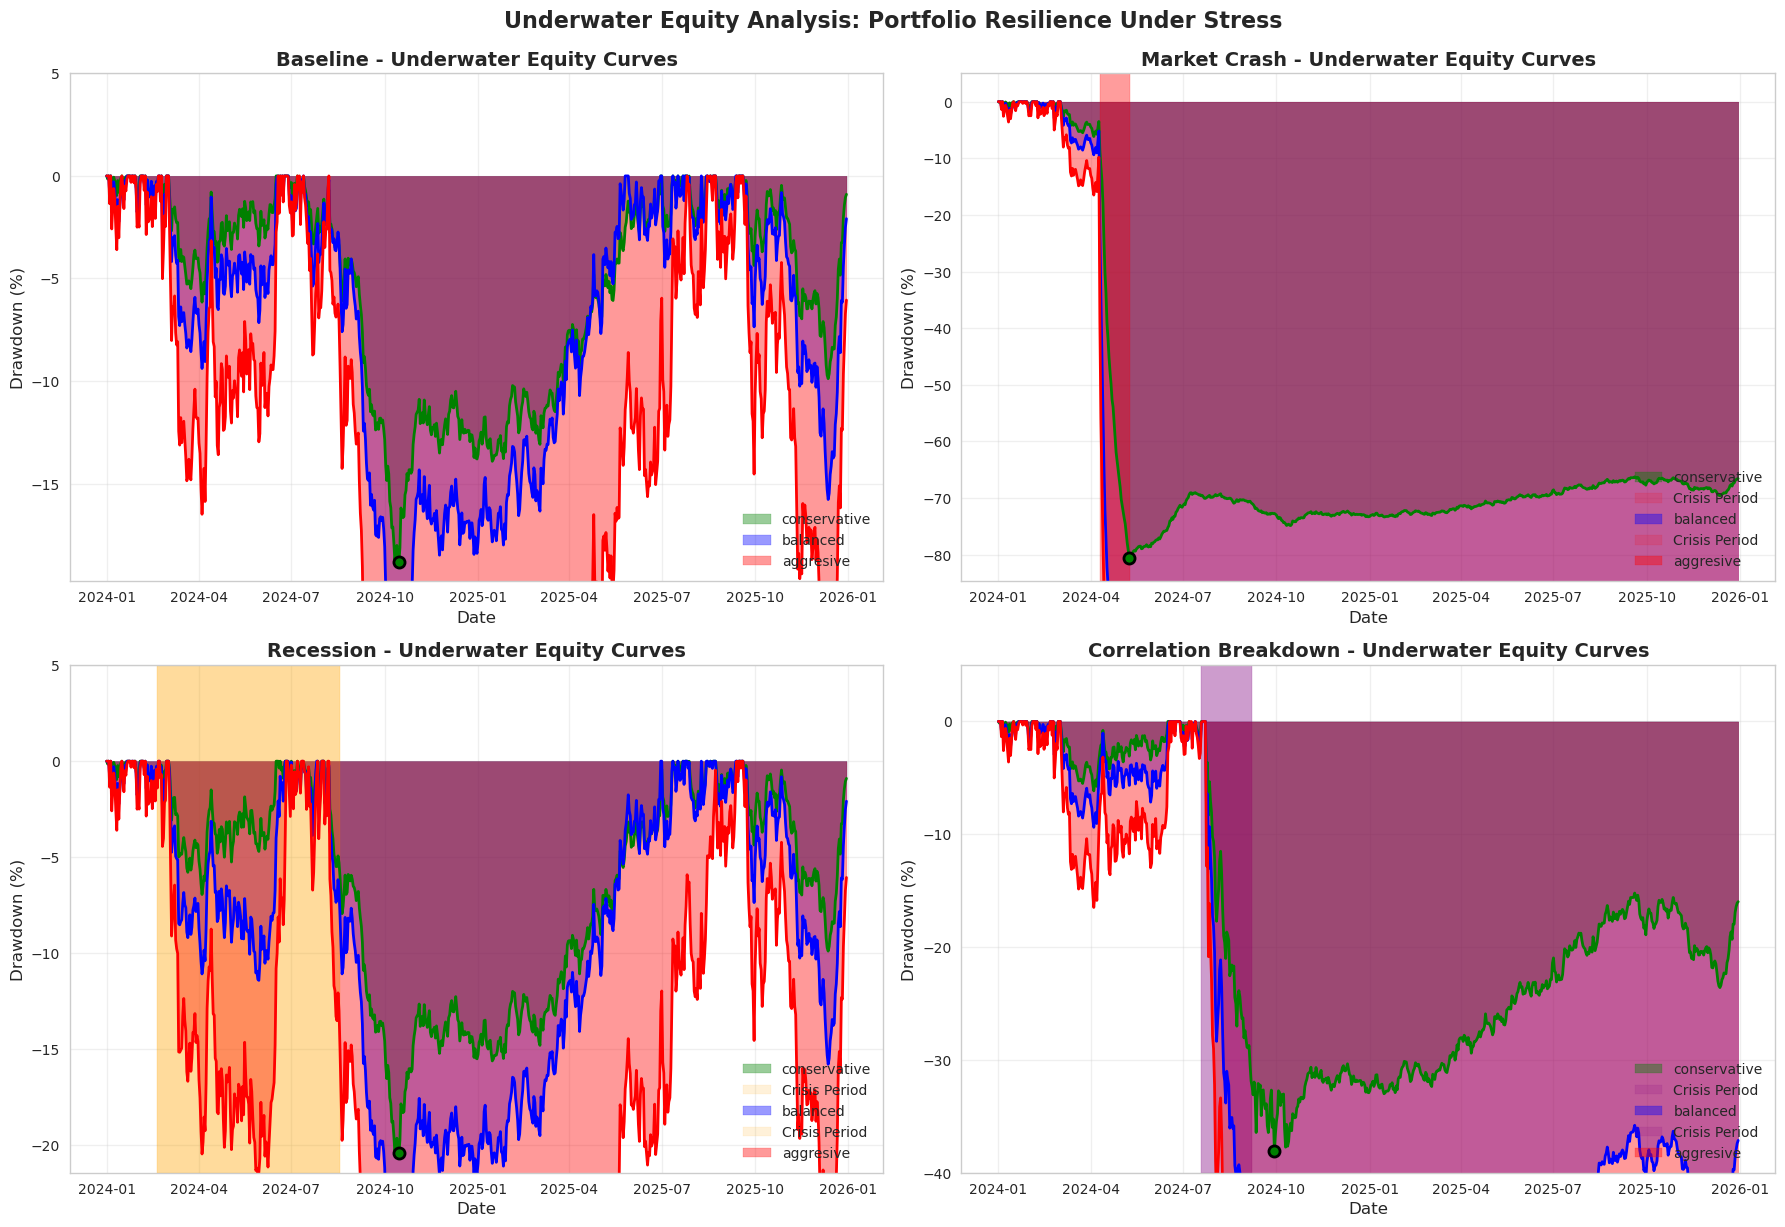

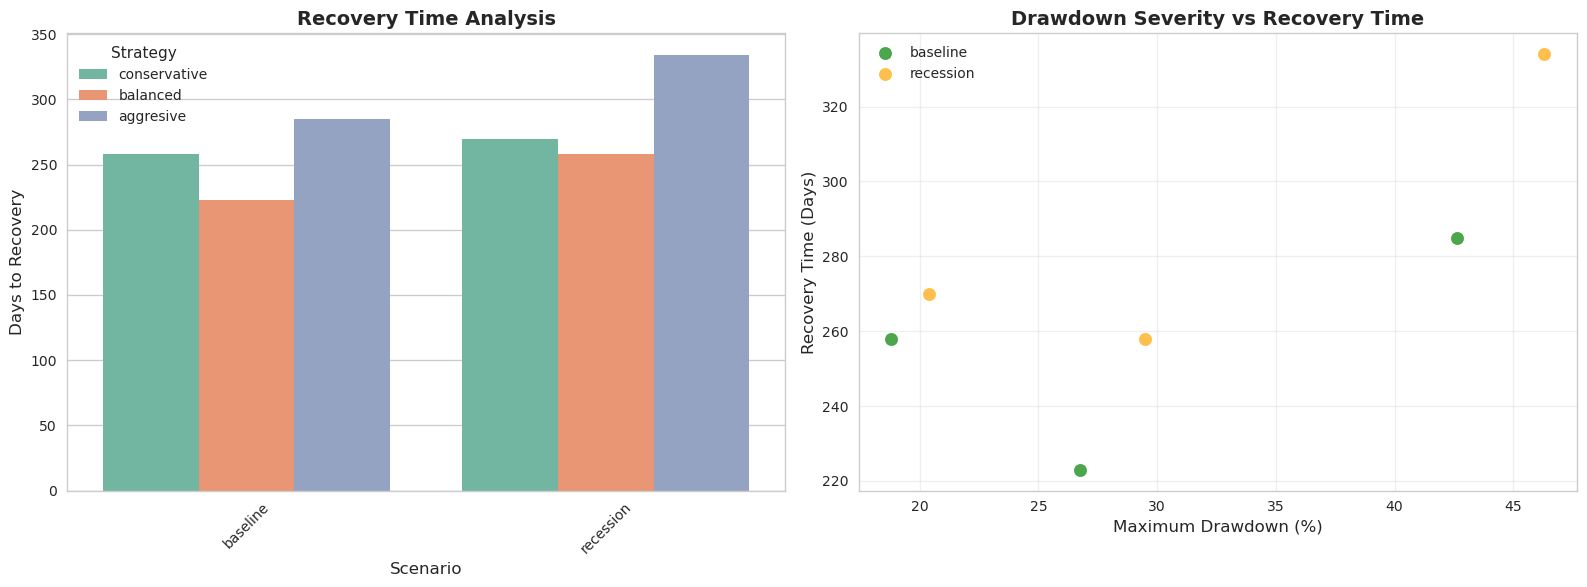

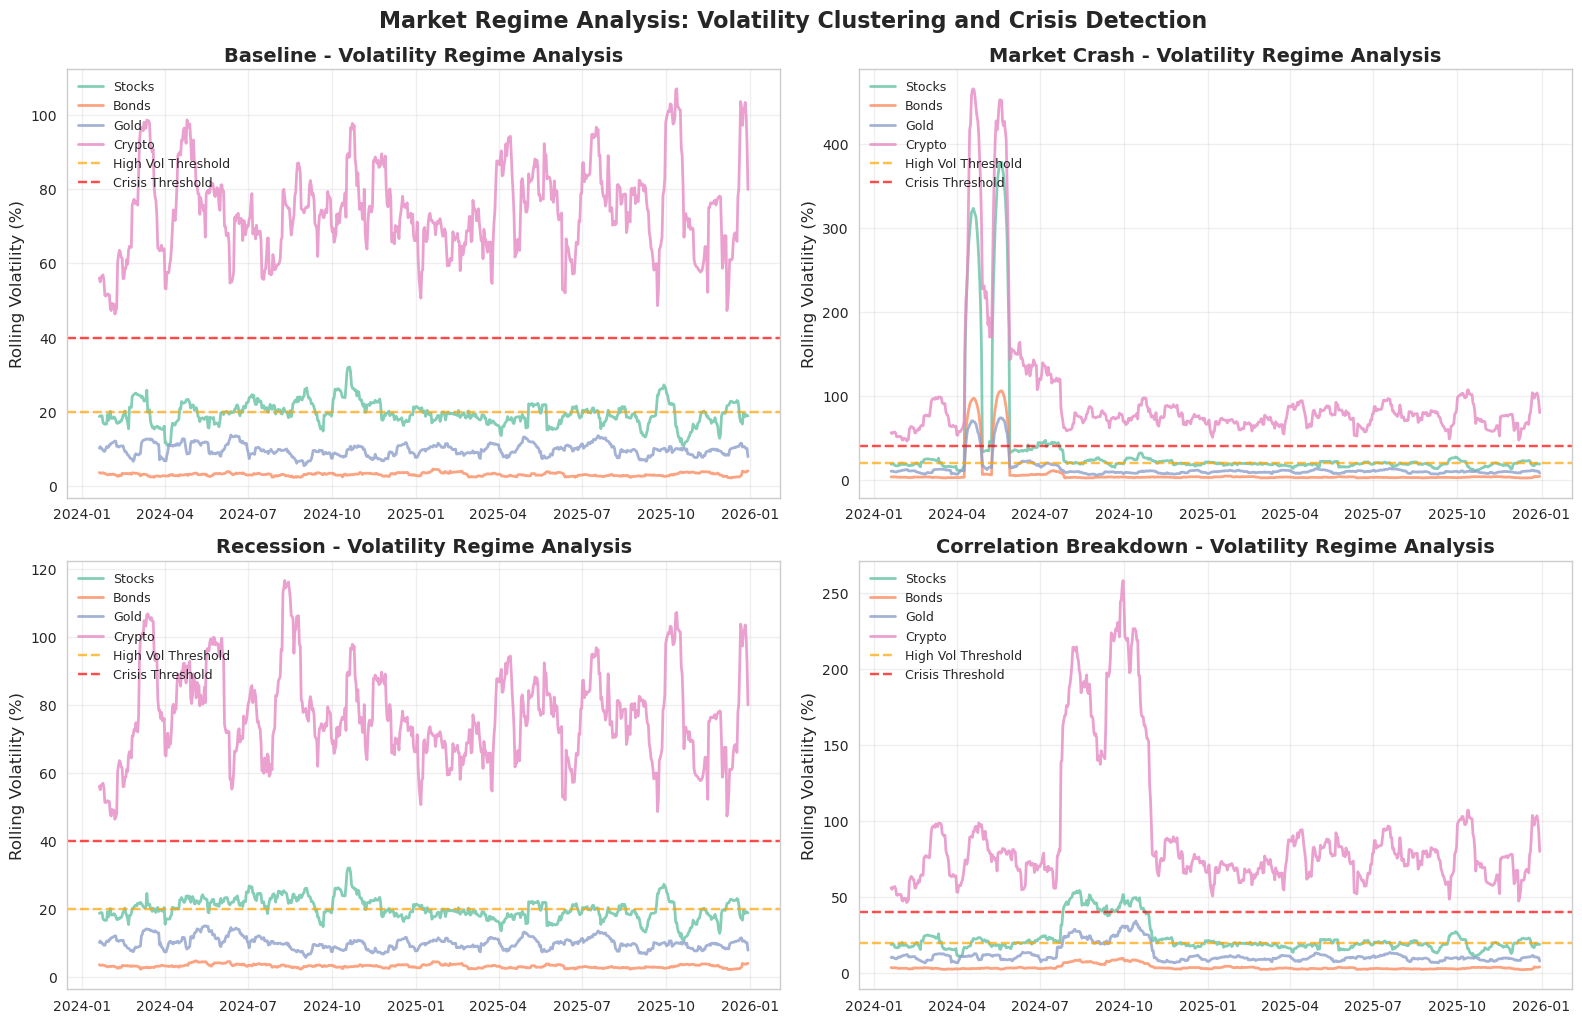

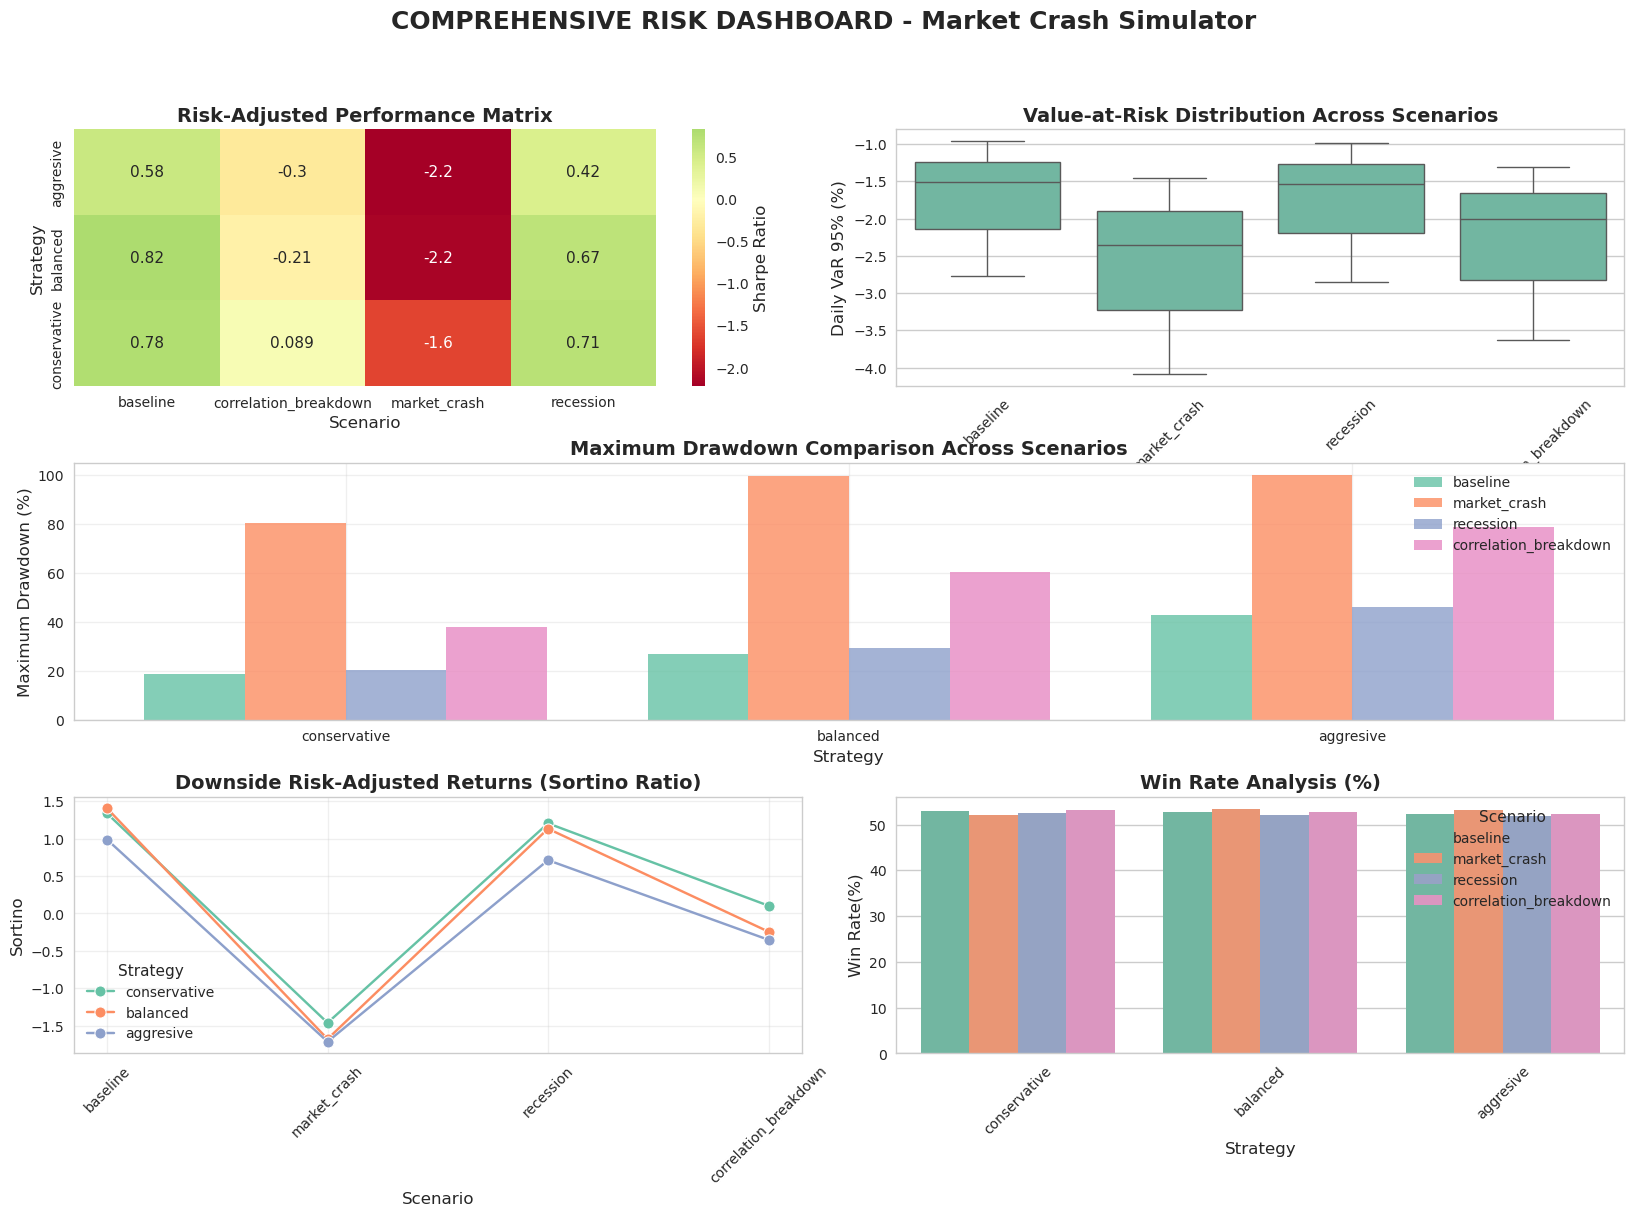


 FINAL ANALYSIS IS COMPLETE!
Market Crash Simulator analysis is ready
This demonstrates advanced understanding of:
• Quantitative Risk Management
• Crisis Modeling and Stress Testing
• Portfolio Optimization Theory
• Institutional Risk Analytics

 PROJECT COMPLETE


In [38]:
risk_analyzer = AdvancedRiskAnalyzer(simulation_results, scenarios, ASSETS)
final_rankings = risk_analyzer.run_final_analysis()
print("\n PROJECT COMPLETE")